In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# importing all libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from collections import Counter
import numpy as np
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

## Functions

In [139]:
def plot_confusion_matrix(confusion_matrix, labels):
    fig, ax = plt.subplots()
    im = ax.imshow(confusion_matrix, cmap='Blues')

    # Set labels
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations
    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, confusion_matrix[i, j], ha="center", va="center", color="black")

    # Set colorbar
    cbar = ax.figure.colorbar(im, ax=ax)

    # Set title and labels
    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

    # Show the plot
    plt.show()


from sklearn.metrics import classification_report, confusion_matrix

def evaluation(y_train_pred, y_test_pred, y_train, y_test):
  print("train_evaluation:\n")
  print(classification_report(y_train_pred, y_train))
  print(confusion_matrix(y_train_pred, y_train))
  print("\ntest_evaluation:\n")
  print(classification_report(y_test_pred, y_test))
  print(confusion_matrix(y_test_pred, y_test))
  labels = ["Level 1", "Level 2", "Level 3"] #, "Level 4", "Level 5"]
  if y_train.nunique() == 5:
      labels = ["Level 1", "Level 2", "Level 3", "Level 4", "Level 5"]
  plot_confusion_matrix(confusion_matrix(y_test_pred, y_test), labels)


# Level1 + Level2 -> Level1, Level3->Level2, Level4+Level5 -> Level3
def club_class(class_var):
    if class_var == 'Level 1' or class_var == 'Level 2':
        return 'Level 1'
    elif class_var == 'Level 3' or class_var == 'Level 4':
        return 'Level 2'
    else:
        return 'Level 3'


In [166]:
def model(data, test_size = 0.2, use_smote_technique=1, target_feature="level_x", club_target=False):
    
    data1 = data

    # Seperate the target variable 
    X = data1.drop(columns = [target_feature])
    y = data1[target_feature]

    # Split the data into test and train
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = 2, stratify = y)
    if club_target:
        y_train = y_train.apply(club_class)
        y_test = y_test.apply(club_class)

    # Smote the data
    if use_smote_technique == 1:
        # Count the class distribution before applying SMOTE
        print("Class distribution before SMOTE:", Counter(y_train))

        # Apply SMOTE to the dataset
        smote = SMOTE(random_state=42)
        X_train, y_train = smote.fit_resample(X_train, y_train)

        # Count the class distribution after applying SMOTE
        print("Class distribution after SMOTE:", Counter(y_train))

    # Random Forest Classifier - Machine Learning Model
    rfc=RandomForestClassifier(n_jobs=-1, random_state=42, n_estimators=15)
    param_grid = {
        'max_depth': [7, 9, 13],                      # Maximum depth of the tree
        'min_samples_split': [2, 5, 10],             # Minimum number of samples required to split a node
        # 'min_samples_leaf': [1, 2, 3],               # Minimum number of samples required at a leaf node
        'max_features': ['auto'],    # Number of features to consider at each split
        'criterion': ['gini', 'entropy', 'log_loss'],
        'oob_score': [True],
        'n_estimators': [100, 200],
        # 'class_weight': ['balanced', 'balanced_subsample']    
    }

    if use_smote_technique != 1:
        param_grid['class_weight'] = ['balanced', 'balanced_subsample'] 

    # Perform grid search to find the best combination of parameters
    grid_search = GridSearchCV(rfc, param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    # Obtain the best values and best score
    print("Best Parameters: ", grid_search.best_params_)
    print("Best Score: ", grid_search.best_score_)

    # Evaluation of model
    y_test_pred = grid_search.best_estimator_.predict(X_test)
    y_train_pred = grid_search.best_estimator_.predict(X_train)
    evaluation(y_train_pred, y_test_pred, y_train, y_test)

    # obtain Best Features
    best_model = grid_search.best_estimator_
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]

    print("Feature Importance Rankings:")
    for i, feature in enumerate(X.columns[indices]):
        print(f"{i + 1}. {feature}: {importances[indices[i]] * 100}")

## Reading input

In [148]:
math_problems = pd.read_csv("../Data/d_data.csv", index_col=0)
math_problems.head()

,Unnamed: 0,problem,level_x,type,modified_problem,no_of_equations,no_of_variables,has_mod,has_logarithm,has_fraction,...,number_of_digits,number_of_numbers,has_digits,has_symbol,symbol_count,has_exp,no_of_exps,has_pow,no_of_pow,gpt_val
0,0,Kevin Kangaroo begins hopping on a number line...,Level 5,3,Kevin Kangaroo begins hopping on a number line...,2,1,False,False,True,...,2,2,True,False,0,False,0,False,0,2
1,1,The ratio of the areas of two squares is $\fra...,Level 4,3,The ratio of the areas of two squares is . Aft...,3,5,False,False,True,...,0,0,False,True,2,False,0,True,1,3
2,2,"If $\sqrt{2\sqrt{t-2}} = \sqrt[4]{7 - t}$, the...",Level 4,3,"If , then find .",1,2,False,False,False,...,4,4,True,True,2,False,0,True,3,4
3,3,Let $t(x) = \sqrt{3x+1}$ and $f(x)=5-t(x)$. Wh...,Level 4,3,Let and . What is ?,3,3,False,False,False,...,1,1,True,False,0,False,0,True,1,3
4,4,James has a total of 66 dollars in his piggy b...,Level 2,3,James has a total of 66 dollars in his piggy b...,0,0,False,False,False,...,0,0,False,False,0,False,0,False,0,2


In [149]:
size_mapping = {"Prealgebra": 1, "Intermediate Algebra": 2, "Algebra": 3}
math_problems['type'] = math_problems['type'].replace(size_mapping)

In [155]:
NER_FEATURES = ['CARDINAL',
 'DATE',
 'EVENT',
 'FAC',
 'GPE',
 'LANGUAGE',
 'LAW',
 'LOC',
 'MONEY',
 'NORP',
 'ORDINAL',
 'ORG',
 'PERCENT',
 'PERSON',
 'PRODUCT',
 'QUANTITY',
 'TIME',
 'WORK_OF_ART']

POS_FEATURES = ['ADJ', 'ADP', 'ADV', 'AUX', 'CONJ', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X']

LINGUISTIC_CAT_FEATURES = ['sentence_count_cat', 'word_count_cat', 'words_per_sentence_cat', 'average_word_length_cat', 'large_words_cat']

LINGUISTIC_NUM_FEATURES = ['sentence_count', 'word_count', 'words_per_sentence', 'average_word_length', 'large_words']

CONDENSED_LINGUISTIC_FEATURES = ['pron_words_ratio', 'pron_sents_ratio', 'adj_sents_ratio',	'adj_words_ratio']

MATH_CAT_FEATURES = ['has_exp', 'has_mod', 'has_logarithm', 'has_fraction', 'has_eq', 'has_neq', 'has_pow', 'has_symbol', 'has_digits']

MATH_NUM_FEATURES = ['no_of_exps', 'no_of_pow', 'symbol_count' ,'mod_count', 'log_count', 'fracs_count', 'eqlts_count', 'neqlts_count', 'max_degree_of_equations', 'number_of_digits', 'number_of_numbers']

MANDATORY_FEATURES = ['no_of_equations', 'no_of_variables', 'type']

MATH_VOCAB_FEATURES = ['number_of_math_vocab']

TARGET_FEATURE = ['level_x']

GPT_TARGET_FEATURE = ['gpt_val']

## Experiment 1: 

Consider the following features

1. Categorised linguistic features
2. Categorical math features (eg: has_exp, has_log)
3. no_of_equations
4. no_of_variables

Run Random forest for the default 5 level classification and report the results

In [204]:
data1 = math_problems[LINGUISTIC_CAT_FEATURES + MATH_CAT_FEATURES + MANDATORY_FEATURES + TARGET_FEATURE]

Class distribution before SMOTE: Counter({'Level 5': 348, 'Level 4': 316, 'Level 3': 313, 'Level 2': 269, 'Level 1': 142})
Class distribution after SMOTE: Counter({'Level 5': 348, 'Level 4': 348, 'Level 3': 348, 'Level 1': 348, 'Level 2': 348})
Best Parameters:  {'criterion': 'gini', 'max_depth': 13, 'max_features': 'auto', 'min_samples_split': 5, 'n_estimators': 100, 'oob_score': True}
Best Score:  0.4833333333333334
train_evaluation:

              precision    recall  f1-score   support

     Level 1       0.89      0.80      0.84       389
     Level 2       0.73      0.77      0.75       332
     Level 3       0.76      0.81      0.78       327
     Level 4       0.78      0.81      0.80       336
     Level 5       0.87      0.85      0.86       356

    accuracy                           0.81      1740
   macro avg       0.81      0.81      0.81      1740
weighted avg       0.81      0.81      0.81      1740

[[311  39  22  12   5]
 [ 17 254  33  18  10]
 [  8  21 264  20  14]
 

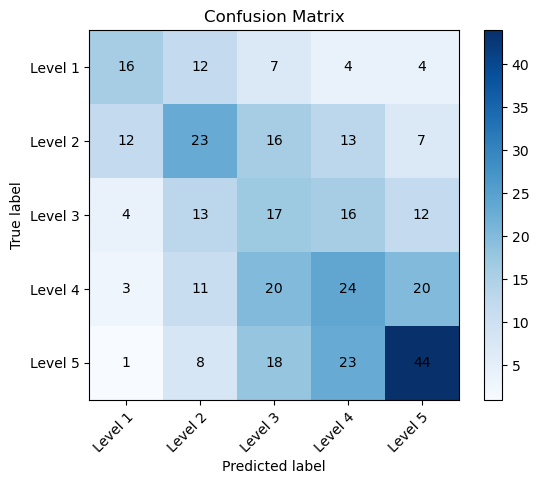

Feature Importance Rankings:
1. no_of_variables: 15.035762375489108
2. large_words_cat: 13.319003047479432
3. words_per_sentence_cat: 11.747539039023508
4. no_of_equations: 11.272540786615524
5. word_count_cat: 10.95887708866919
6. average_word_length_cat: 8.420031876813235
7. has_symbol: 5.593498025782573
8. has_pow: 5.08370589506913
9. sentence_count_cat: 3.9539587765661377
10. has_fraction: 3.7180632707978023
11. has_eq: 3.3788725356527523
12. has_digits: 3.239760379225504
13. has_neq: 1.8651951328550151
14. has_mod: 1.2365708252135126
15. has_logarithm: 1.1766209447475686
16. has_exp: 0.0
17. type: 0.0


In [205]:
model(data1)

Best Parameters:  {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 9, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 200, 'oob_score': True}
Best Score:  0.36814533932420845
train_evaluation:

              precision    recall  f1-score   support

     Level 1       0.91      0.54      0.68       238
     Level 2       0.69      0.73      0.71       256
     Level 3       0.67      0.79      0.72       265
     Level 4       0.67      0.82      0.74       259
     Level 5       0.86      0.81      0.83       370

    accuracy                           0.75      1388
   macro avg       0.76      0.74      0.74      1388
weighted avg       0.77      0.75      0.75      1388

[[129  45  35  20   9]
 [  5 186  33  22  10]
 [  2  13 209  23  18]
 [  5  11  18 213  12]
 [  1  14  18  38 299]]

test_evaluation:

              precision    recall  f1-score   support

     Level 1       0.56      0.39      0.46        51
     Level 2       0.33      0.31      0

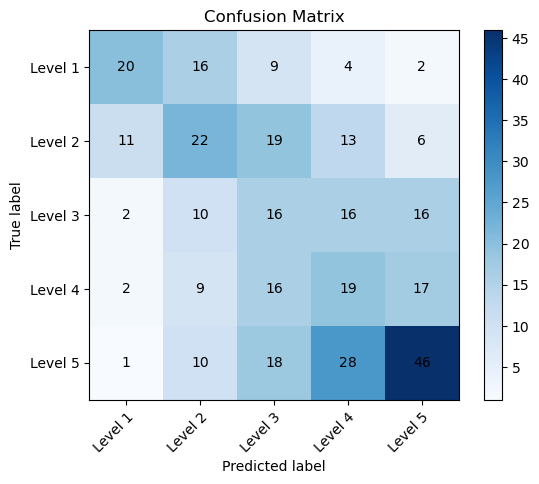

Feature Importance Rankings:
1. no_of_variables: 15.257255948145135
2. large_words_cat: 13.724986020804753
3. word_count_cat: 11.216774270752854
4. no_of_equations: 11.207366354218737
5. words_per_sentence_cat: 10.808668937837858
6. average_word_length_cat: 7.650458180092699
7. has_symbol: 6.147314719498006
8. has_pow: 5.562155291945974
9. sentence_count_cat: 4.391912077973314
10. has_fraction: 3.61062621338136
11. has_digits: 3.2264235789997637
12. has_eq: 2.8174166258687476
13. has_neq: 2.0794428034825163
14. has_logarithm: 1.2992328665559185
15. has_mod: 0.9999661104423707
16. has_exp: 0.0
17. type: 0.0


In [206]:
model(data1, use_smote_technique=0)

Class distribution before SMOTE: Counter({3: 548, 2: 525, 4: 212, 1: 61, 5: 42})
Class distribution after SMOTE: Counter({2: 548, 3: 548, 4: 548, 5: 548, 1: 548})
Best Parameters:  {'criterion': 'gini', 'max_depth': 13, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 200, 'oob_score': True}
Best Score:  0.6262773722627738
train_evaluation:

              precision    recall  f1-score   support

           1       0.93      0.82      0.87       624
           2       0.76      0.85      0.80       491
           3       0.77      0.90      0.83       471
           4       0.87      0.82      0.84       586
           5       0.95      0.92      0.94       568

    accuracy                           0.86      2740
   macro avg       0.86      0.86      0.86      2740
weighted avg       0.87      0.86      0.86      2740

[[510  52  32  26   4]
 [ 11 417  40  18   5]
 [  2  31 422  12   4]
 [ 21  36  39 478  12]
 [  4  12  15  14 523]]

test_evaluation:

              pre

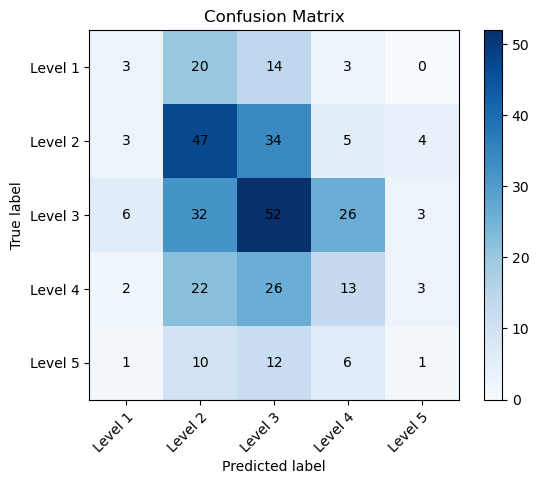

Feature Importance Rankings:
1. no_of_variables: 16.43235345009161
2. large_words_cat: 12.09323633360647
3. words_per_sentence_cat: 11.469996320107192
4. no_of_equations: 11.027822772208571
5. word_count_cat: 9.952943012030483
6. average_word_length_cat: 7.96188346246409
7. has_symbol: 6.319134581971249
8. has_pow: 6.197592394967998
9. has_fraction: 4.579369944596187
10. has_digits: 3.9811793974742153
11. sentence_count_cat: 3.4909990024525808
12. has_eq: 3.403423196323422
13. has_neq: 1.3685530045788092
14. has_logarithm: 0.8934421360453008
15. has_mod: 0.8280709910818241
16. has_exp: 0.0
17. type: 0.0


In [207]:
data1 = math_problems[LINGUISTIC_CAT_FEATURES + MATH_CAT_FEATURES + MANDATORY_FEATURES + GPT_TARGET_FEATURE]

model(data1, target_feature=GPT_TARGET_FEATURE[0])

Best Parameters:  {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 13, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 100, 'oob_score': True}
Best Score:  0.37823805937199695
train_evaluation:

              precision    recall  f1-score   support

           1       0.98      0.47      0.63       129
           2       0.78      0.89      0.83       463
           3       0.79      0.92      0.85       466
           4       0.89      0.73      0.80       258
           5       1.00      0.58      0.74        72

    accuracy                           0.82      1388
   macro avg       0.89      0.72      0.77      1388
weighted avg       0.83      0.82      0.81      1388

[[ 60  40  21   8   0]
 [  0 411  45   7   0]
 [  0  31 431   4   0]
 [  0  32  38 188   0]
 [  1  11  13   5  42]]

test_evaluation:

              precision    recall  f1-score   support

           1       0.07      0.04      0.05        25
           2       0.44      0.47      0.4

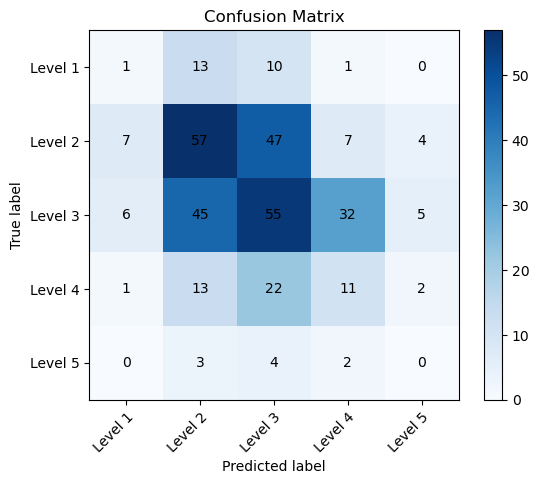

Feature Importance Rankings:
1. no_of_variables: 15.609733128952138
2. words_per_sentence_cat: 11.989665793381388
3. no_of_equations: 11.192892780610464
4. large_words_cat: 10.981831596368428
5. word_count_cat: 9.841977004963363
6. average_word_length_cat: 8.975128659420115
7. has_pow: 5.836859838999201
8. has_symbol: 5.376447168794164
9. has_fraction: 4.749135222143965
10. sentence_count_cat: 4.419067698049312
11. has_eq: 3.750253129297353
12. has_digits: 3.415838838407133
13. has_neq: 1.9395310978732645
14. has_mod: 0.9707020609110422
15. has_logarithm: 0.9509359818286659
16. has_exp: 0.0
17. type: 0.0


In [208]:
model(data1, use_smote_technique=0, target_feature=GPT_TARGET_FEATURE[0])

## Experiment 2: 

Consider the following features

1. Categorised linguistic features
2. All numerical math features

Run Random forest with default 5 class classification and report the results

In [209]:
data2 = math_problems[LINGUISTIC_CAT_FEATURES + MATH_NUM_FEATURES + MANDATORY_FEATURES + TARGET_FEATURE]

Class distribution before SMOTE: Counter({'Level 5': 348, 'Level 4': 316, 'Level 3': 313, 'Level 2': 269, 'Level 1': 142})
Class distribution after SMOTE: Counter({'Level 5': 348, 'Level 4': 348, 'Level 3': 348, 'Level 1': 348, 'Level 2': 348})


Best Parameters:  {'criterion': 'entropy', 'max_depth': 13, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 100, 'oob_score': True}
Best Score:  0.48908045977011494
train_evaluation:

              precision    recall  f1-score   support

     Level 1       0.96      0.88      0.92       379
     Level 2       0.85      0.92      0.89       322
     Level 3       0.90      0.94      0.92       334
     Level 4       0.91      0.90      0.90       355
     Level 5       0.95      0.94      0.94       350

    accuracy                           0.92      1740
   macro avg       0.92      0.92      0.92      1740
weighted avg       0.92      0.92      0.92      1740

[[335  26  10   5   3]
 [  2 297  14   5   4]
 [  2   5 314   8   5]
 [  7  15   8 318   7]
 [  2   5   2  12 329]]

test_evaluation:

              precision    recall  f1-score   support

     Level 1       0.47      0.40      0.43        43
     Level 2       0.28      0.30      0.29        64
     Level 3 

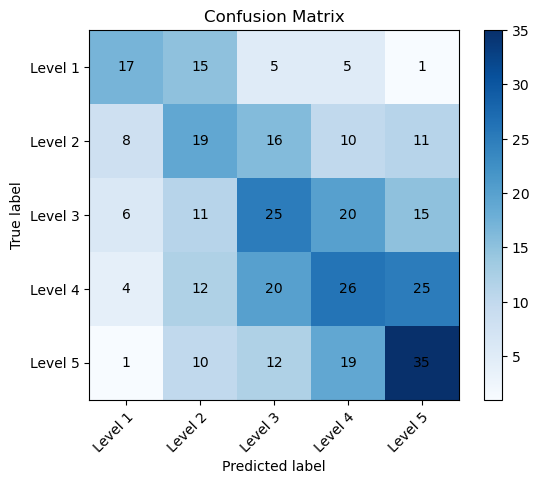

Feature Importance Rankings:
1. large_words_cat: 10.458881415739146
2. no_of_variables: 9.375659085110126
3. number_of_digits: 9.104861035370309
4. words_per_sentence_cat: 9.048630347888889
5. word_count_cat: 8.863299276779529
6. symbol_count: 8.264277530075773
7. no_of_equations: 7.0820634552544215
8. number_of_numbers: 6.8956780695060615
9. max_degree_of_equations: 6.846250525472636
10. no_of_pow: 6.386301991301162
11. average_word_length_cat: 5.772737995415186
12. fracs_count: 3.488748160675846
13. sentence_count_cat: 3.3503100095673073
14. eqlts_count: 2.6040939540067645
15. neqlts_count: 1.058752360076274
16. mod_count: 0.7428033586759417
17. log_count: 0.6566514290846192
18. no_of_exps: 0.0
19. type: 0.0


In [210]:
model(data2)

Best Parameters:  {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 13, 'max_features': 'auto', 'min_samples_split': 5, 'n_estimators': 200, 'oob_score': True}
Best Score:  0.3811339376152508
train_evaluation:

              precision    recall  f1-score   support

     Level 1       0.93      0.75      0.83       177
     Level 2       0.80      0.89      0.84       242
     Level 3       0.85      0.86      0.85       308
     Level 4       0.84      0.88      0.86       301
     Level 5       0.93      0.90      0.91       360

    accuracy                           0.87      1388
   macro avg       0.87      0.86      0.86      1388
weighted avg       0.87      0.87      0.87      1388

[[132  19  14   8   4]
 [  2 215  14   7   4]
 [  3  11 265  19  10]
 [  4  13  11 266   7]
 [  1  11   9  16 323]]

test_evaluation:

              precision    recall  f1-score   support

     Level 1       0.39      0.31      0.35        45
     Level 2       0.24      0.25

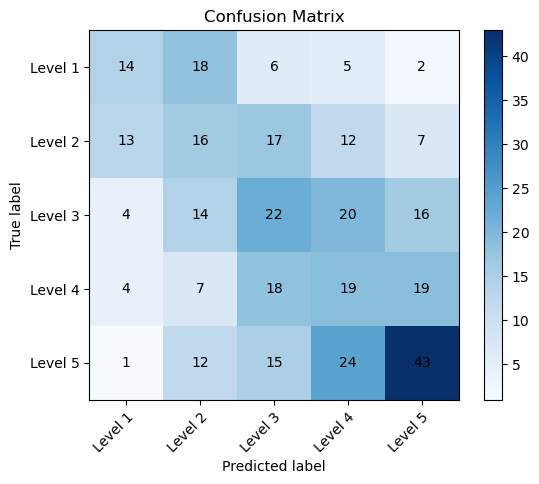

Feature Importance Rankings:
1. large_words_cat: 10.494154369894147
2. no_of_variables: 9.425020971887102
3. number_of_digits: 9.279941408205824
4. words_per_sentence_cat: 8.480721409642033
5. word_count_cat: 8.33906976649802
6. symbol_count: 7.896124019242028
7. number_of_numbers: 7.100913047284384
8. max_degree_of_equations: 7.067842348613233
9. no_of_equations: 6.925266375109788
10. no_of_pow: 5.998321791883526
11. average_word_length_cat: 5.802447846196089
12. fracs_count: 3.847757343554804
13. sentence_count_cat: 3.2009615228535173
14. eqlts_count: 2.788751038983653
15. neqlts_count: 1.4002282723731623
16. mod_count: 1.029021898792686
17. log_count: 0.9234565689860105
18. no_of_exps: 0.0
19. type: 0.0


In [211]:
model(data2, use_smote_technique=0)

In [212]:
data2 = math_problems[LINGUISTIC_CAT_FEATURES + MATH_NUM_FEATURES + MANDATORY_FEATURES + GPT_TARGET_FEATURE]

Class distribution before SMOTE: Counter({3: 548, 2: 525, 4: 212, 1: 61, 5: 42})
Class distribution after SMOTE: Counter({2: 548, 3: 548, 4: 548, 5: 548, 1: 548})
Best Parameters:  {'criterion': 'entropy', 'max_depth': 13, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 200, 'oob_score': True}
Best Score:  0.6558394160583942
train_evaluation:

              precision    recall  f1-score   support

           1       0.97      0.88      0.92       604
           2       0.86      0.91      0.89       520
           3       0.87      0.95      0.91       502
           4       0.91      0.91      0.91       544
           5       1.00      0.96      0.98       570

    accuracy                           0.92      2740
   macro avg       0.92      0.92      0.92      2740
weighted avg       0.92      0.92      0.92      2740

[[532  32  14  26   0]
 [  9 473  29   9   0]
 [  1  17 477   6   1]
 [  4  21  23 496   0]
 [  2   5   5  11 547]]

test_evaluation:

              

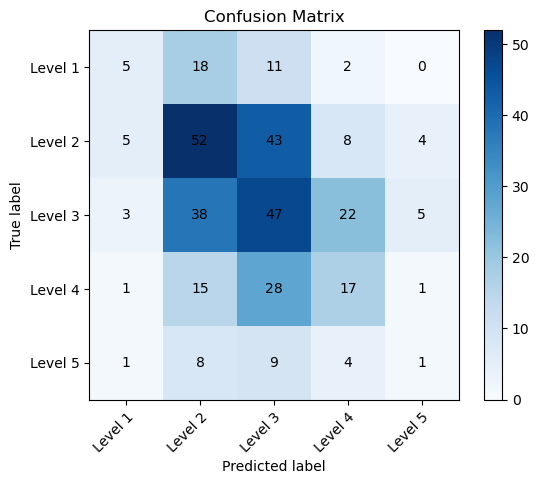

Feature Importance Rankings:
1. number_of_digits: 10.541494587276555
2. no_of_variables: 9.967236910211655
3. large_words_cat: 9.95167993930179
4. words_per_sentence_cat: 9.459860523106183
5. symbol_count: 7.835659746588955
6. number_of_numbers: 7.625308290386017
7. no_of_equations: 7.288569008151723
8. word_count_cat: 7.282996358207987
9. no_of_pow: 7.25283023577046
10. max_degree_of_equations: 6.479949376115471
11. average_word_length_cat: 5.6782925545533125
12. fracs_count: 3.7667211190851
13. sentence_count_cat: 2.994034876824428
14. eqlts_count: 2.04607554886784
15. neqlts_count: 0.7828828405986957
16. mod_count: 0.5546144802006272
17. log_count: 0.4917936047532075
18. no_of_exps: 0.0
19. type: 0.0


In [213]:
model(data2, target_feature=GPT_TARGET_FEATURE[0])

Best Parameters:  {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 13, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 100, 'oob_score': True}
Best Score:  0.4128067942757707
train_evaluation:

              precision    recall  f1-score   support

           1       1.00      0.71      0.83        86
           2       0.90      0.92      0.91       513
           3       0.87      0.96      0.91       495
           4       0.92      0.82      0.87       238
           5       1.00      0.75      0.86        56

    accuracy                           0.90      1388
   macro avg       0.94      0.83      0.88      1388
weighted avg       0.90      0.90      0.90      1388

[[ 61  15   7   3   0]
 [  0 472  35   6   0]
 [  0  15 477   3   0]
 [  0  19  23 196   0]
 [  0   4   6   4  42]]

test_evaluation:

              precision    recall  f1-score   support

           1       0.07      0.08      0.07        13
           2       0.51      0.46

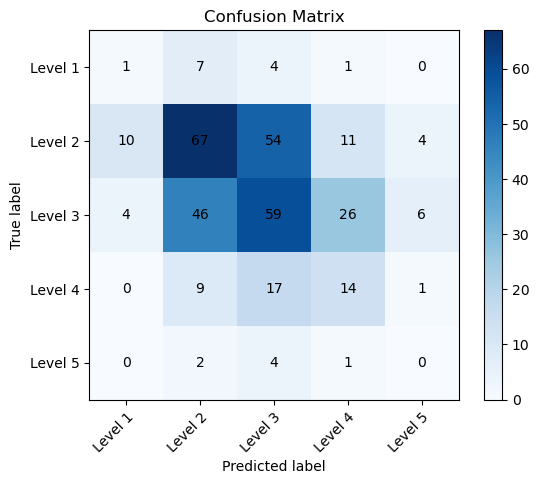

Feature Importance Rankings:
1. number_of_digits: 10.170165966707613
2. no_of_variables: 9.426838751937074
3. words_per_sentence_cat: 8.64986430198206
4. large_words_cat: 8.26173242994776
5. symbol_count: 8.07243519061963
6. number_of_numbers: 7.715807728291156
7. no_of_pow: 7.619562001959884
8. max_degree_of_equations: 7.124746974475003
9. no_of_equations: 6.954360644284844
10. word_count_cat: 6.6333579498622415
11. average_word_length_cat: 5.554128604687722
12. fracs_count: 4.469746749930507
13. sentence_count_cat: 3.6981981340853647
14. eqlts_count: 2.8063987907595536
15. neqlts_count: 1.3392486713318061
16. mod_count: 0.8876019189031787
17. log_count: 0.6158051902346046
18. no_of_exps: 0.0
19. type: 0.0


In [214]:
model(data2, target_feature=GPT_TARGET_FEATURE[0], use_smote_technique=0)

## Experiment 3: 

Consider the following features

1. Categorised linguistic features
2. Categorical math features
3. POS features
4. no_of_equations
5. no_of_variables

Run Random Forest on the default 5 class classification and report the results



In [215]:
data3 = math_problems[LINGUISTIC_CAT_FEATURES + MATH_CAT_FEATURES + POS_FEATURES + MANDATORY_FEATURES + TARGET_FEATURE]

Class distribution before SMOTE: Counter({'Level 5': 348, 'Level 4': 316, 'Level 3': 313, 'Level 2': 269, 'Level 1': 142})
Class distribution after SMOTE: Counter({'Level 5': 348, 'Level 4': 348, 'Level 3': 348, 'Level 1': 348, 'Level 2': 348})


Best Parameters:  {'criterion': 'entropy', 'max_depth': 13, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 200, 'oob_score': True}
Best Score:  0.5172413793103449
train_evaluation:

              precision    recall  f1-score   support

     Level 1       0.96      0.91      0.93       367
     Level 2       0.92      0.91      0.92       351
     Level 3       0.94      0.94      0.94       349
     Level 4       0.93      0.97      0.95       333
     Level 5       0.97      0.99      0.98       340

    accuracy                           0.94      1740
   macro avg       0.94      0.94      0.94      1740
weighted avg       0.94      0.94      0.94      1740

[[334  17   8   4   4]
 [ 13 321   7   8   2]
 [  1   7 327  10   4]
 [  0   3   6 323   1]
 [  0   0   0   3 337]]

test_evaluation:

              precision    recall  f1-score   support

     Level 1       0.53      0.40      0.45        48
     Level 2       0.33      0.31      0.32        70
     Level 3  

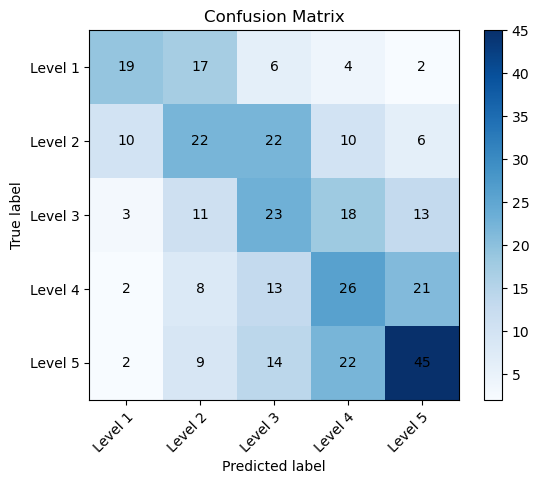

Feature Importance Rankings:
1. no_of_variables: 7.653453841456817
2. NOUN: 6.317588121392367
3. ADP: 5.852416247285793
4. large_words_cat: 5.74370328480038
5. ADJ: 5.542461006694423
6. DET: 5.4223864236243955
7. PUNCT: 5.269600275628334
8. no_of_equations: 5.190103527395818
9. VERB: 4.888613730835644
10. words_per_sentence_cat: 4.095288096392387
11. AUX: 4.000495460451179
12. PRON: 3.879845692620713
13. has_symbol: 3.7428634090673083
14. word_count_cat: 3.6303558824882765
15. CCONJ: 3.3460194949426896
16. average_word_length_cat: 3.2936899878312977
17. SCONJ: 3.2918845642760273
18. has_pow: 3.281204333741243
19. NUM: 2.6334657980421654
20. has_fraction: 2.050078294920456
21. ADV: 1.924907818068007
22. has_digits: 1.6743669734213085
23. PROPN: 1.6555031457051883
24. has_eq: 1.6263366431426114
25. sentence_count_cat: 0.9739559383130336
26. PART: 0.8363807031954644
27. has_neq: 0.6395060822712652
28. has_logarithm: 0.49819141932747024
29. has_mod: 0.48916315580851716
30. X: 0.31881586395

In [216]:
model(data3)

Best Parameters:  {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 13, 'max_features': 'auto', 'min_samples_split': 5, 'n_estimators': 200, 'oob_score': True}
Best Score:  0.3940939667038933
train_evaluation:

              precision    recall  f1-score   support

     Level 1       0.98      0.74      0.84       189
     Level 2       0.84      0.91      0.88       249
     Level 3       0.91      0.88      0.90       323
     Level 4       0.91      0.96      0.93       297
     Level 5       0.93      0.98      0.96       330

    accuracy                           0.91      1388
   macro avg       0.91      0.89      0.90      1388
weighted avg       0.91      0.91      0.91      1388

[[139  25  12   6   7]
 [  2 227   8  10   2]
 [  1  15 285  11  11]
 [  0   1   6 286   4]
 [  0   1   2   3 324]]

test_evaluation:

              precision    recall  f1-score   support

     Level 1       0.58      0.44      0.50        48
     Level 2       0.28      0.29

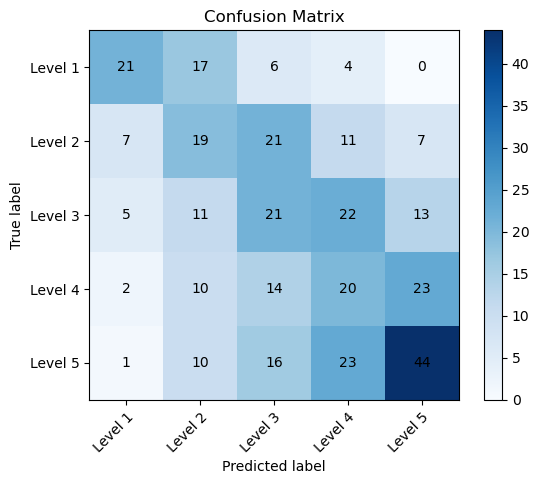

Feature Importance Rankings:
1. no_of_variables: 8.07830439584846
2. NOUN: 6.385858513738245
3. ADP: 5.6903774125148665
4. ADJ: 5.5496114323802646
5. PUNCT: 5.4992912370908416
6. large_words_cat: 5.356616504927247
7. DET: 5.229289466897619
8. no_of_equations: 5.124057618505469
9. VERB: 4.874013773631612
10. AUX: 4.236567808238843
11. words_per_sentence_cat: 3.9807612126994893
12. PRON: 3.859690263107881
13. has_symbol: 3.2703811469920434
14. word_count_cat: 3.2479226686134752
15. NUM: 3.224637524157772
16. SCONJ: 3.1703088971593756
17. CCONJ: 3.116007405893043
18. average_word_length_cat: 3.089912109353507
19. has_pow: 2.8206133451200506
20. ADV: 2.160371395761948
21. PROPN: 1.9208558118166643
22. has_fraction: 1.8448925301459431
23. has_eq: 1.7559359976662692
24. has_digits: 1.4164391852587144
25. sentence_count_cat: 1.0792374019039714
26. PART: 1.0116949949392873
27. has_neq: 0.845138092471341
28. has_mod: 0.6923804808696423
29. has_logarithm: 0.6866413303225367
30. X: 0.395534547502

In [217]:
model(data3, use_smote_technique=0)

In [218]:
data3 = math_problems[LINGUISTIC_CAT_FEATURES + MATH_CAT_FEATURES + POS_FEATURES + MANDATORY_FEATURES + GPT_TARGET_FEATURE]

Class distribution before SMOTE: Counter({3: 548, 2: 525, 4: 212, 1: 61, 5: 42})
Class distribution after SMOTE: Counter({2: 548, 3: 548, 4: 548, 5: 548, 1: 548})
Best Parameters:  {'criterion': 'gini', 'max_depth': 13, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 200, 'oob_score': True}
Best Score:  0.7047445255474453
train_evaluation:

              precision    recall  f1-score   support

           1       1.00      0.92      0.96       594
           2       0.92      0.95      0.93       530
           3       0.91      0.97      0.94       511
           4       0.95      0.96      0.96       545
           5       0.99      0.97      0.98       560

    accuracy                           0.95      2740
   macro avg       0.95      0.95      0.95      2740
weighted avg       0.96      0.95      0.95      2740

[[547  22  12  12   1]
 [  1 502  19   6   2]
 [  0  10 498   3   0]
 [  0  10  13 522   0]
 [  0   4   6   5 545]]

test_evaluation:

              pre

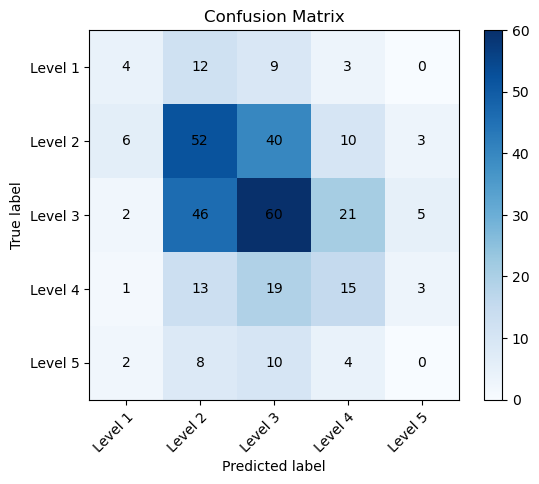

Feature Importance Rankings:
1. no_of_variables: 7.62975516816649
2. PUNCT: 7.0025079695398365
3. NOUN: 5.73655517114948
4. DET: 5.4692897278999455
5. ADJ: 5.440584492416703
6. VERB: 5.228126813633501
7. words_per_sentence_cat: 4.732474940197067
8. ADP: 4.703441479067304
9. no_of_equations: 4.556261469429053
10. AUX: 4.4548295533958235
11. large_words_cat: 4.371523908678105
12. PRON: 3.9594472891367185
13. has_pow: 3.9444108173570163
14. has_symbol: 3.8964255788403457
15. SCONJ: 3.2733242192076815
16. word_count_cat: 3.2673987678331726
17. average_word_length_cat: 3.1222946456314564
18. CCONJ: 2.891505683777889
19. NUM: 2.786610575068954
20. PROPN: 2.694909490785509
21. has_fraction: 2.2803193900478638
22. has_digits: 1.6319517094857467
23. ADV: 1.611317497042826
24. has_eq: 1.3740187252286944
25. sentence_count_cat: 1.068343677829445
26. PART: 0.6407630426463262
27. X: 0.6272827557446677
28. has_neq: 0.5113155610073974
29. has_mod: 0.3989406433578273
30. has_logarithm: 0.3601907492458

In [219]:
model(data3, target_feature=GPT_TARGET_FEATURE[0])

Best Parameters:  {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 13, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 200, 'oob_score': True}
Best Score:  0.4401890761758824
train_evaluation:

              precision    recall  f1-score   support

           1       1.00      0.64      0.78        95
           2       0.93      0.94      0.94       521
           3       0.91      0.98      0.94       506
           4       0.94      0.93      0.93       216
           5       1.00      0.84      0.91        50

    accuracy                           0.93      1388
   macro avg       0.96      0.87      0.90      1388
weighted avg       0.93      0.93      0.93      1388

[[ 61  18  11   5   0]
 [  0 490  26   5   0]
 [  0   9 496   1   0]
 [  0   5  11 200   0]
 [  0   3   4   1  42]]

test_evaluation:

              precision    recall  f1-score   support

           1       0.13      0.17      0.15        12
           2       0.53      0.49      0.51

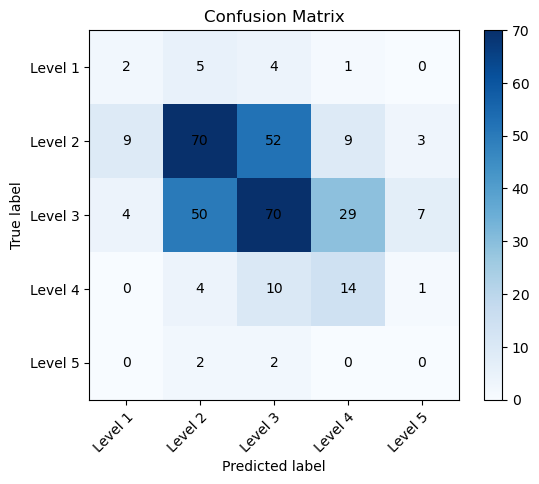

Feature Importance Rankings:
1. no_of_variables: 7.092178243510235
2. NOUN: 6.315803822886751
3. PUNCT: 5.958845250878056
4. ADJ: 5.590915520926071
5. DET: 5.419530780685166
6. ADP: 5.003582993018882
7. VERB: 4.950201535040026
8. AUX: 4.508275143079912
9. words_per_sentence_cat: 4.424748894385641
10. no_of_equations: 4.3465235949859755
11. large_words_cat: 4.312852661116689
12. PRON: 4.088310761658288
13. has_pow: 3.771581368424706
14. CCONJ: 3.4795357155281974
15. SCONJ: 3.4655510966965966
16. word_count_cat: 3.0701849924656024
17. average_word_length_cat: 2.9382208848110487
18. has_symbol: 2.885401232729303
19. NUM: 2.8578515923696304
20. PROPN: 2.8348521663659443
21. has_fraction: 2.691715267979374
22. ADV: 2.053351096560013
23. has_eq: 1.7858108527555747
24. has_digits: 1.461784019112183
25. sentence_count_cat: 1.0391014951563011
26. has_neq: 0.8791832269295058
27. PART: 0.8124007912431369
28. X: 0.6916214720488282
29. has_mod: 0.4507737926520623
30. SYM: 0.44620797181887184
31. ha

In [220]:
model(data3, target_feature=GPT_TARGET_FEATURE[0], use_smote_technique=0)

## Experiment 4: 

Consider the following features

1. Categorised linguistic features
2. Numerical math features
3. POS features

Run Random Forest on the default 5 class classification and report the results



In [221]:
data4 = math_problems[LINGUISTIC_CAT_FEATURES + MATH_NUM_FEATURES + POS_FEATURES + TARGET_FEATURE]

Class distribution before SMOTE: Counter({'Level 5': 348, 'Level 4': 316, 'Level 3': 313, 'Level 2': 269, 'Level 1': 142})
Class distribution after SMOTE: Counter({'Level 5': 348, 'Level 4': 348, 'Level 3': 348, 'Level 1': 348, 'Level 2': 348})


Best Parameters:  {'criterion': 'entropy', 'max_depth': 13, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 200, 'oob_score': True}
Best Score:  0.5252873563218391
train_evaluation:

              precision    recall  f1-score   support

     Level 1       0.99      0.93      0.96       372
     Level 2       0.94      0.98      0.96       332
     Level 3       0.97      0.96      0.96       352
     Level 4       0.97      0.99      0.98       341
     Level 5       0.98      1.00      0.99       343

    accuracy                           0.97      1740
   macro avg       0.97      0.97      0.97      1740
weighted avg       0.97      0.97      0.97      1740

[[345  18   6   1   2]
 [  2 326   2   2   0]
 [  1   4 337   7   3]
 [  0   0   3 337   1]
 [  0   0   0   1 342]]

test_evaluation:

              precision    recall  f1-score   support

     Level 1       0.50      0.41      0.45        44
     Level 2       0.31      0.32      0.32        66
     Level 3  

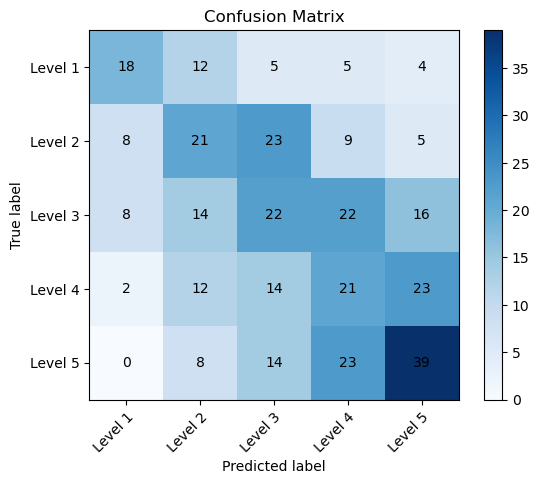

Feature Importance Rankings:
1. number_of_digits: 6.277605035779689
2. symbol_count: 6.145264878439337
3. max_degree_of_equations: 5.781472314381279
4. NOUN: 5.573516867734123
5. large_words_cat: 5.184286782429505
6. ADP: 5.12820194137886
7. DET: 4.901371401418752
8. VERB: 4.86680338734543
9. ADJ: 4.751046629392953
10. PUNCT: 4.730440205898635
11. number_of_numbers: 4.659301661245371
12. no_of_pow: 4.411947174889911
13. words_per_sentence_cat: 3.771747057801309
14. AUX: 3.5892393125495214
15. word_count_cat: 3.502855459564027
16. PRON: 3.4998652276533377
17. CCONJ: 3.110975378526701
18. SCONJ: 3.008287005789687
19. average_word_length_cat: 2.9007358902206706
20. NUM: 2.882110564651998
21. fracs_count: 2.3357676342345233
22. ADV: 1.9410504463446905
23. eqlts_count: 1.6369392321780596
24. PROPN: 1.5732274263704673
25. sentence_count_cat: 0.9926501311884387
26. PART: 0.7402019604734781
27. neqlts_count: 0.6623385048672618
28. log_count: 0.4407170046094776
29. mod_count: 0.4232865919005388

In [222]:
model(data4)

Best Parameters:  {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 13, 'max_features': 'auto', 'min_samples_split': 5, 'n_estimators': 200, 'oob_score': True}
Best Score:  0.40132197491104593
train_evaluation:

              precision    recall  f1-score   support

     Level 1       0.98      0.82      0.89       170
     Level 2       0.90      0.92      0.91       263
     Level 3       0.94      0.91      0.92       323
     Level 4       0.92      0.97      0.94       300
     Level 5       0.94      0.99      0.96       332

    accuracy                           0.93      1388
   macro avg       0.94      0.92      0.93      1388
weighted avg       0.93      0.93      0.93      1388

[[139  15   8   4   4]
 [  2 243   5   9   4]
 [  1  10 294  10   8]
 [  0   1   5 290   4]
 [  0   0   1   3 328]]

test_evaluation:

              precision    recall  f1-score   support

     Level 1       0.50      0.38      0.43        47
     Level 2       0.25      0.2

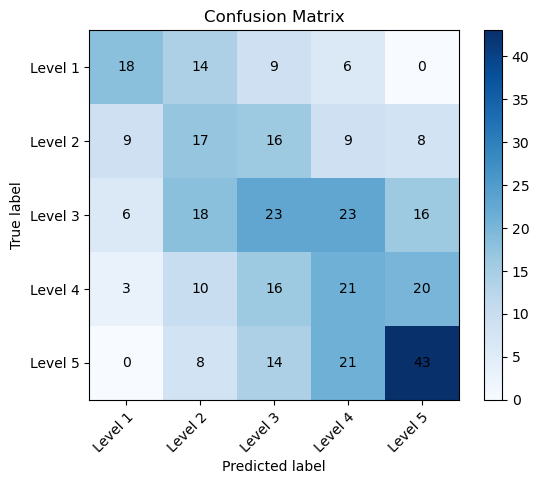

Feature Importance Rankings:
1. number_of_digits: 6.178127547053735
2. max_degree_of_equations: 6.102374816522601
3. NOUN: 5.6181688674553865
4. symbol_count: 5.331559672901862
5. ADP: 5.284905388076988
6. large_words_cat: 5.096701309016193
7. ADJ: 4.8609036460786585
8. DET: 4.757374573918921
9. PUNCT: 4.710847303027325
10. VERB: 4.684981253702204
11. number_of_numbers: 4.516566165114915
12. no_of_pow: 4.151940284732806
13. words_per_sentence_cat: 3.7106542826981572
14. PRON: 3.6866770670790383
15. AUX: 3.4312765602070185
16. word_count_cat: 3.4078165900308486
17. NUM: 3.0930419479687283
18. SCONJ: 2.9335061112970213
19. CCONJ: 2.925580281747354
20. average_word_length_cat: 2.58456135170484
21. fracs_count: 2.4679888816004754
22. ADV: 2.0562511203765315
23. eqlts_count: 1.9048273709255954
24. PROPN: 1.692767865484351
25. PART: 1.023694188238378
26. sentence_count_cat: 0.9896635602294698
27. neqlts_count: 0.8796748154087424
28. log_count: 0.6036658936951264
29. mod_count: 0.586825354514

In [223]:
model(data4, use_smote_technique=0)

In [224]:
data4 = math_problems[LINGUISTIC_CAT_FEATURES + MATH_NUM_FEATURES + POS_FEATURES + GPT_TARGET_FEATURE]

Class distribution before SMOTE: Counter({3: 548, 2: 525, 4: 212, 1: 61, 5: 42})
Class distribution after SMOTE: Counter({2: 548, 3: 548, 4: 548, 5: 548, 1: 548})
Best Parameters:  {'criterion': 'entropy', 'max_depth': 13, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 200, 'oob_score': True}
Best Score:  0.7036496350364965
train_evaluation:

              precision    recall  f1-score   support

           1       1.00      0.94      0.97       580
           2       0.95      0.98      0.96       529
           3       0.96      0.99      0.97       531
           4       0.98      0.97      0.98       551
           5       1.00      0.99      1.00       549

    accuracy                           0.97      2740
   macro avg       0.97      0.98      0.97      2740
weighted avg       0.98      0.97      0.97      2740

[[547  16   6   9   2]
 [  1 518  10   0   0]
 [  0   5 524   2   0]
 [  0   8   7 536   0]
 [  0   1   1   1 546]]

test_evaluation:

              

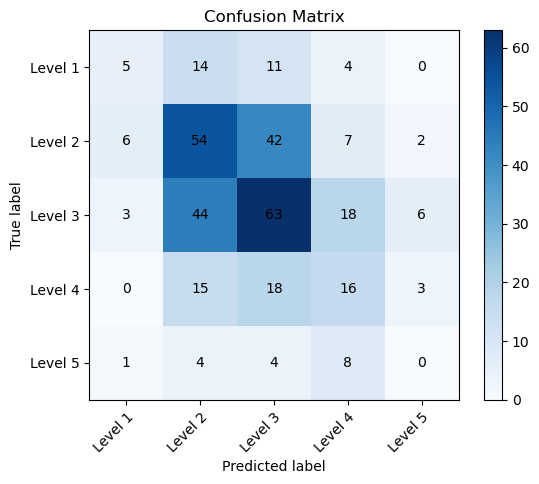

Feature Importance Rankings:
1. number_of_digits: 6.583917460825461
2. PUNCT: 6.514794156816378
3. no_of_pow: 5.539940502897662
4. NOUN: 5.390083569464634
5. max_degree_of_equations: 5.175104232891905
6. number_of_numbers: 5.162915760283763
7. symbol_count: 5.125689407346528
8. VERB: 4.923275455099706
9. ADJ: 4.763174442438544
10. DET: 4.651669261367392
11. ADP: 4.502418701132138
12. words_per_sentence_cat: 4.3877120077642555
13. AUX: 4.370293106640516
14. large_words_cat: 4.239002846764368
15. PRON: 3.4621651094695483
16. SCONJ: 3.0883420457098194
17. average_word_length_cat: 3.022454415114779
18. word_count_cat: 2.9995686512627784
19. fracs_count: 2.7351136673649985
20. CCONJ: 2.6260603895167725
21. PROPN: 2.4687041231138345
22. NUM: 2.288242980210147
23. ADV: 1.3482312630346955
24. eqlts_count: 1.2073141665556821
25. sentence_count_cat: 0.9430788716695085
26. PART: 0.5884758119690979
27. X: 0.5680758104119719
28. neqlts_count: 0.418214386093138
29. mod_count: 0.35561763002971053
30.

In [225]:
model(data4, target_feature=GPT_TARGET_FEATURE[0])

Best Parameters:  {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 13, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 200, 'oob_score': True}
Best Score:  0.45387372412539284
train_evaluation:

              precision    recall  f1-score   support

           1       1.00      0.85      0.92        72
           2       0.97      0.96      0.96       528
           3       0.95      0.99      0.97       529
           4       0.97      0.95      0.96       216
           5       1.00      0.98      0.99        43

    accuracy                           0.96      1388
   macro avg       0.98      0.94      0.96      1388
weighted avg       0.97      0.96      0.96      1388

[[ 61   7   3   1   0]
 [  0 508  16   4   0]
 [  0   5 523   1   0]
 [  0   5   6 205   0]
 [  0   0   0   1  42]]

test_evaluation:

              precision    recall  f1-score   support

           1       0.13      0.20      0.16        10
           2       0.50      

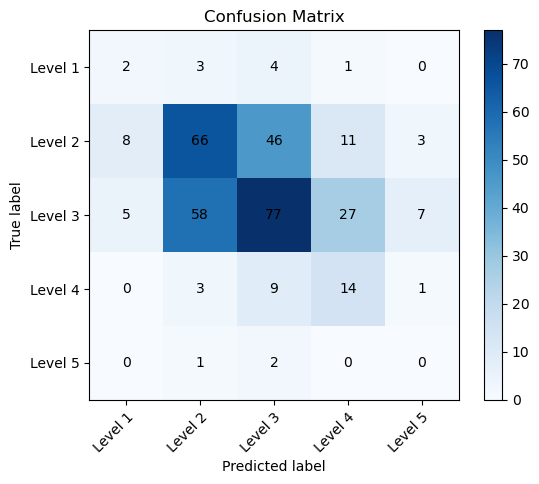

Feature Importance Rankings:
1. number_of_digits: 6.145367807400833
2. no_of_pow: 5.792320590619982
3. NOUN: 5.495489107758416
4. symbol_count: 5.358657251834601
5. PUNCT: 5.332070495230549
6. max_degree_of_equations: 5.2451871935277
7. number_of_numbers: 5.14750330405438
8. ADJ: 5.112025100183616
9. DET: 4.941331736576526
10. VERB: 4.52044585598195
11. ADP: 4.486647486411015
12. AUX: 4.259045763788833
13. large_words_cat: 4.242207663759239
14. words_per_sentence_cat: 4.106462789423942
15. PRON: 3.5489273573527185
16. CCONJ: 2.9516538680031026
17. fracs_count: 2.8896327067746657
18. SCONJ: 2.8119916782699916
19. word_count_cat: 2.7111943455948575
20. PROPN: 2.514411744772214
21. NUM: 2.4841866182997707
22. average_word_length_cat: 2.423092542933941
23. ADV: 1.6029846871589968
24. eqlts_count: 1.576755718537941
25. sentence_count_cat: 1.0193082581132566
26. X: 0.8151289773979652
27. neqlts_count: 0.7229947334770465
28. PART: 0.6846563882735849
29. mod_count: 0.41418753062669506
30. log_

In [226]:
model(data4, target_feature=GPT_TARGET_FEATURE[0], use_smote_technique=0)

## Experiment 5

Consider the following features

1. Categorised linguistic features
2. Numerical Math features
3. POS features
4. Math vocab

In [227]:
data5 = math_problems[LINGUISTIC_CAT_FEATURES + MATH_NUM_FEATURES + POS_FEATURES + MATH_VOCAB_FEATURES + TARGET_FEATURE]

Class distribution before SMOTE: Counter({'Level 5': 348, 'Level 4': 316, 'Level 3': 313, 'Level 2': 269, 'Level 1': 142})
Class distribution after SMOTE: Counter({'Level 5': 348, 'Level 4': 348, 'Level 3': 348, 'Level 1': 348, 'Level 2': 348})


Best Parameters:  {'criterion': 'entropy', 'max_depth': 13, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 200, 'oob_score': True}
Best Score:  0.5235632183908046
train_evaluation:

              precision    recall  f1-score   support

     Level 1       0.99      0.94      0.96       368
     Level 2       0.95      0.98      0.97       339
     Level 3       0.96      0.96      0.96       348
     Level 4       0.97      0.99      0.98       342
     Level 5       0.98      1.00      0.99       343

    accuracy                           0.97      1740
   macro avg       0.97      0.97      0.97      1740
weighted avg       0.97      0.97      0.97      1740

[[345  14   6   1   2]
 [  2 332   4   1   0]
 [  1   2 335   7   3]
 [  0   0   3 338   1]
 [  0   0   0   1 342]]

test_evaluation:

              precision    recall  f1-score   support

     Level 1       0.50      0.39      0.44        46
     Level 2       0.33      0.33      0.33        66
     Level 3  

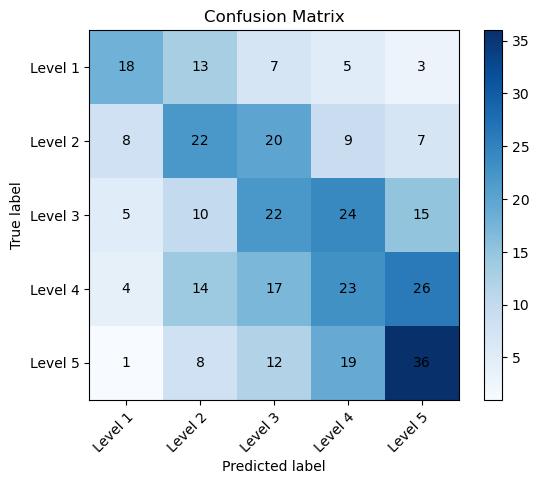

Feature Importance Rankings:
1. number_of_digits: 5.919707088345763
2. symbol_count: 5.8793632640282905
3. max_degree_of_equations: 5.591218336484079
4. NOUN: 5.275861527546606
5. number_of_math_vocab: 4.936370660796509
6. ADP: 4.900009062346135
7. DET: 4.800088859224717
8. large_words_cat: 4.737678938640685
9. VERB: 4.708845923696132
10. PUNCT: 4.5586504713415
11. ADJ: 4.493835588591517
12. number_of_numbers: 4.420419292591418
13. no_of_pow: 4.3627456090746275
14. words_per_sentence_cat: 3.4564933056852807
15. AUX: 3.4087627806371223
16. word_count_cat: 3.3894658996869285
17. PRON: 3.274597003109144
18. CCONJ: 2.8980180273554104
19. SCONJ: 2.8867889447277437
20. average_word_length_cat: 2.7428679259656885
21. NUM: 2.709906824435405
22. fracs_count: 2.160241899284659
23. ADV: 1.8148054815834658
24. eqlts_count: 1.600675044374028
25. PROPN: 1.3971316570956782
26. sentence_count_cat: 0.9617996662072951
27. PART: 0.7445613985476449
28. neqlts_count: 0.6327257698216986
29. mod_count: 0.446

In [228]:
model(data5)

Best Parameters:  {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 13, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 200, 'oob_score': True}
Best Score:  0.39697685894605617
train_evaluation:

              precision    recall  f1-score   support

     Level 1       0.99      0.90      0.94       155
     Level 2       0.96      0.98      0.97       265
     Level 3       0.97      0.95      0.96       318
     Level 4       0.96      0.99      0.97       306
     Level 5       0.98      0.99      0.99       344

    accuracy                           0.97      1388
   macro avg       0.97      0.96      0.97      1388
weighted avg       0.97      0.97      0.97      1388

[[140   8   3   2   2]
 [  0 259   4   1   1]
 [  2   2 303   8   3]
 [  0   0   3 303   0]
 [  0   0   0   2 342]]

test_evaluation:

              precision    recall  f1-score   support

     Level 1       0.47      0.42      0.45        40
     Level 2       0.36      0.33      0.3

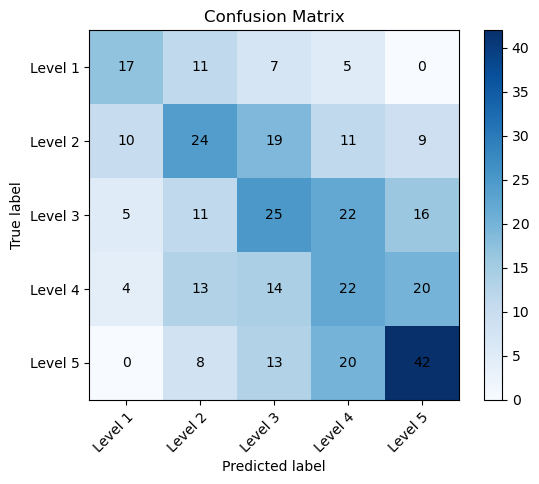

Feature Importance Rankings:
1. number_of_digits: 5.986786513088443
2. max_degree_of_equations: 5.756992910532363
3. NOUN: 5.175732129886148
4. symbol_count: 5.1272388256666686
5. ADP: 4.840669765243986
6. PUNCT: 4.749366746129479
7. number_of_numbers: 4.73870100722353
8. ADJ: 4.690409762583052
9. number_of_math_vocab: 4.598904276640975
10. DET: 4.545172472246733
11. VERB: 4.495203752189816
12. large_words_cat: 4.359414527940997
13. no_of_pow: 4.094505711606558
14. words_per_sentence_cat: 3.5684405574751206
15. AUX: 3.5445754677263053
16. PRON: 3.2811840528498086
17. NUM: 3.0693034080126664
18. word_count_cat: 2.950853216224435
19. SCONJ: 2.8591324825147044
20. CCONJ: 2.786272075459525
21. average_word_length_cat: 2.547402445950549
22. fracs_count: 2.3672930619191153
23. ADV: 1.9407234926164596
24. eqlts_count: 1.8633977197119154
25. PROPN: 1.6407846560001045
26. sentence_count_cat: 1.0378022410054215
27. PART: 0.9705826093901448
28. neqlts_count: 0.7613168195352829
29. mod_count: 0.53

In [229]:
model(data5, use_smote_technique=0)

In [230]:
data5 = math_problems[LINGUISTIC_CAT_FEATURES + MATH_NUM_FEATURES + POS_FEATURES + MATH_VOCAB_FEATURES + GPT_TARGET_FEATURE]

Class distribution before SMOTE: Counter({3: 548, 2: 525, 4: 212, 1: 61, 5: 42})
Class distribution after SMOTE: Counter({2: 548, 3: 548, 4: 548, 5: 548, 1: 548})
Best Parameters:  {'criterion': 'entropy', 'max_depth': 13, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 200, 'oob_score': True}
Best Score:  0.7087591240875912
train_evaluation:

              precision    recall  f1-score   support

           1       1.00      0.95      0.97       577
           2       0.95      0.98      0.96       534
           3       0.96      0.99      0.97       534
           4       0.97      0.98      0.98       545
           5       1.00      0.99      1.00       550

    accuracy                           0.98      2740
   macro avg       0.98      0.98      0.98      2740
weighted avg       0.98      0.98      0.98      2740

[[547  13   7   9   1]
 [  1 522   9   2   0]
 [  0   6 526   2   0]
 [  0   6   5 534   0]
 [  0   1   1   1 547]]

test_evaluation:

              

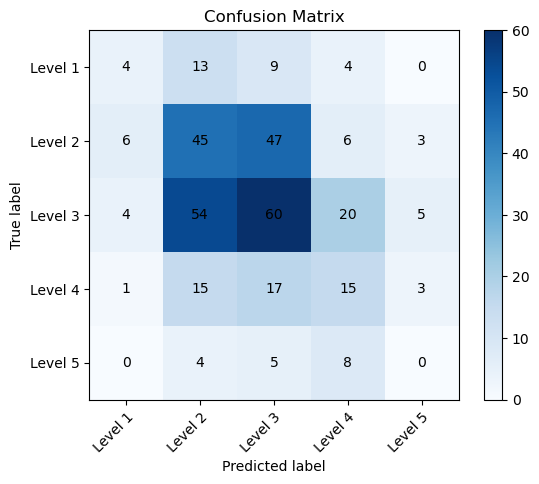

Feature Importance Rankings:
1. number_of_digits: 6.308051787813518
2. PUNCT: 6.201495923478525
3. no_of_pow: 5.439230445453596
4. NOUN: 5.218776175905579
5. number_of_numbers: 5.168206142394582
6. symbol_count: 4.910803179325965
7. max_degree_of_equations: 4.775609660906775
8. ADJ: 4.567300932764852
9. VERB: 4.542965287933912
10. DET: 4.5062253755832105
11. number_of_math_vocab: 4.4506761063575535
12. ADP: 4.228010210263684
13. words_per_sentence_cat: 4.087210240547431
14. AUX: 4.018427489854268
15. large_words_cat: 3.980485581367537
16. PRON: 3.3805410109546385
17. word_count_cat: 3.1267084534761396
18. SCONJ: 2.891715105893161
19. average_word_length_cat: 2.7222461679551477
20. fracs_count: 2.64607934911109
21. CCONJ: 2.592994994497961
22. PROPN: 2.3845331027388297
23. NUM: 2.120502281707642
24. ADV: 1.265125899454004
25. eqlts_count: 1.1188171157035065
26. sentence_count_cat: 0.8686450493296848
27. X: 0.6100645310476287
28. PART: 0.5867475791536313
29. neqlts_count: 0.3774407492190

In [231]:
model(data5, target_feature=GPT_TARGET_FEATURE[0])

Best Parameters:  {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 13, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 200, 'oob_score': True}
Best Score:  0.4459418746591174
train_evaluation:

              precision    recall  f1-score   support

           1       1.00      0.78      0.88        78
           2       0.96      0.96      0.96       524
           3       0.95      0.98      0.97       528
           4       0.96      0.95      0.96       215
           5       1.00      0.98      0.99        43

    accuracy                           0.96      1388
   macro avg       0.97      0.93      0.95      1388
weighted avg       0.96      0.96      0.96      1388

[[ 61  10   6   1   0]
 [  0 503  16   5   0]
 [  0   7 520   1   0]
 [  0   5   6 204   0]
 [  0   0   0   1  42]]

test_evaluation:

              precision    recall  f1-score   support

           1       0.13      0.18      0.15        11
           2       0.49      0.49      0.49

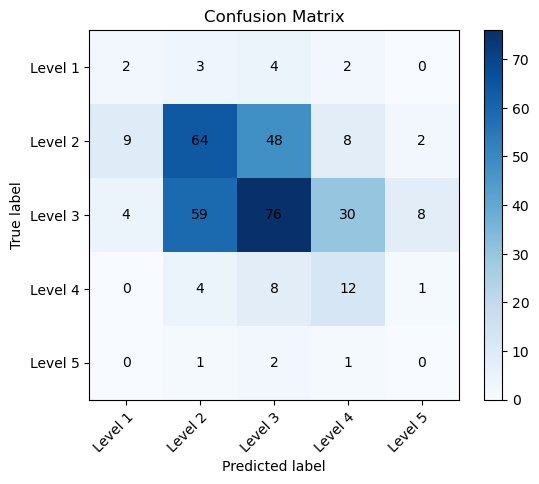

Feature Importance Rankings:
1. number_of_digits: 5.953704332851113
2. PUNCT: 5.346857554332574
3. no_of_pow: 5.3314025171881925
4. symbol_count: 5.072207334907363
5. NOUN: 5.068472444559305
6. max_degree_of_equations: 5.029367616971108
7. number_of_numbers: 4.870539413766052
8. ADJ: 4.823764351709599
9. DET: 4.673959430595755
10. VERB: 4.266304860097988
11. number_of_math_vocab: 4.169379707814746
12. ADP: 4.148498030996804
13. AUX: 3.818721313048326
14. large_words_cat: 3.623140982412493
15. PRON: 3.5552726170969025
16. words_per_sentence_cat: 3.5497997095818334
17. fracs_count: 3.005341406555116
18. SCONJ: 2.870993520477853
19. CCONJ: 2.832438332284084
20. word_count_cat: 2.731056632467735
21. PROPN: 2.637787588109544
22. NUM: 2.451822241467225
23. average_word_length_cat: 2.3814071850741554
24. ADV: 1.653841516393732
25. eqlts_count: 1.6416411671748465
26. sentence_count_cat: 1.0721243157675675
27. X: 0.8281492090107869
28. neqlts_count: 0.8027520171950807
29. PART: 0.73644880779878

In [232]:
model(data5, target_feature=GPT_TARGET_FEATURE[0], use_smote_technique=0)

## Experiment 6

Consider the following features
1. Math (cat/Num)
2. cohmetrix

In [174]:
def get_cohmetrix_merged_data(columns):
    cohmetrix = pd.read_csv("../Data/cohmetrix_final.csv")
    print("Shape of cohmetric features: ", cohmetrix.shape)

    math_data = math_problems[['problem'] + columns]

    print("math features shape: ", math_data.shape)

    data6 = pd.merge(cohmetrix,math_data, on='problem', how='inner')
    data6.drop(columns=['problem'], inplace=True)

    print("final dataframe shape: ", data6.shape)
    return data6

In [176]:
data6 = get_cohmetrix_merged_data(MATH_NUM_FEATURES + MANDATORY_FEATURES + TARGET_FEATURE)

Shape of cohmetric features:  (3584, 107)
math features shape:  (1736, 16)
final dataframe shape:  (1736, 121)


Class distribution before SMOTE: Counter({'Level 5': 348, 'Level 4': 316, 'Level 3': 313, 'Level 2': 269, 'Level 1': 142})
Class distribution after SMOTE: Counter({'Level 5': 348, 'Level 4': 348, 'Level 3': 348, 'Level 1': 348, 'Level 2': 348})
Best Parameters:  {'criterion': 'entropy', 'max_depth': 13, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 200, 'oob_score': True}
Best Score:  0.5408045977011493
train_evaluation:

              precision    recall  f1-score   support

     Level 1       1.00      1.00      1.00       348
     Level 2       0.99      1.00      1.00       347
     Level 3       1.00      0.99      1.00       349
     Level 4       1.00      1.00      1.00       347
     Level 5       1.00      1.00      1.00       349

    accuracy                           1.00      1740
   macro avg       1.00      1.00      1.00      1740
weighted avg       1.00      1.00      1.00      1740

[[348   0   0   0   0]
 [  0 346   1   0   0]
 [  0   1 347   1   0

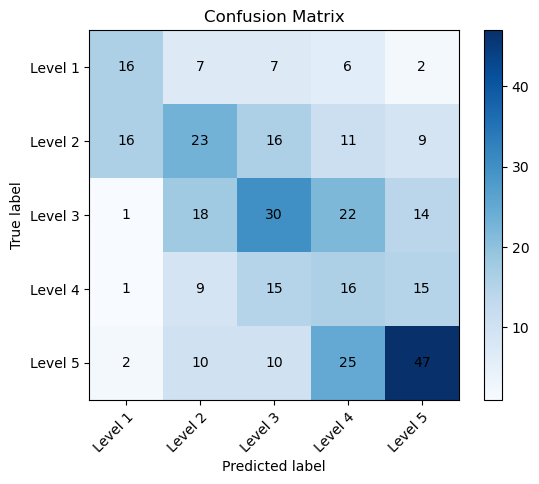

Feature Importance Rankings:
1. DESWC: 2.4756847295326487
2. DESWLlt: 2.345753450642184
3. DESWLltd: 2.3407804910067993
4. no_of_variables: 2.202481037357834
5. symbol_count: 2.170961976987922
6. RDL2: 2.0863675558774104
7. PCTEMPz: 1.985210847912501
8. CNCAll: 1.8995837021406947
9. WRDHYPv: 1.8556304587547472
10. WRDMEAc: 1.8539825587484977
11. WRDAOAc: 1.8473403640913335
12. PCVERBz: 1.84645346330496
13. PCDCz: 1.8207517610882105
14. PCCNCz: 1.799760907946039
15. DESSL: 1.7774221886681398
16. WRDADJ: 1.7760486270364781
17. DESWLsyd: 1.7732982029246458
18. WRDHYPn: 1.7383612759171576
19. WRDIMGc: 1.7063571107952578
20. PCCONNz: 1.7048307492175132
21. PCSYNz: 1.7017764957737782
22. PCREFz: 1.691121878322003
23. WRDFRQmc: 1.6783113139829453
24. RDFKGL: 1.673220609629659
25. WRDHYPnv: 1.6663954848331255
26. PCNARz: 1.6662270730609816
27. WRDPOLc: 1.6590799567011851
28. PCSYNp: 1.646630384560026
29. PCREFp: 1.6391157195723693
30. WRDADV: 1.6354824523626101
31. DRPP: 1.6301095441151225
32.

In [171]:
model(data6)

Best Parameters:  {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 13, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 100, 'oob_score': True}
Best Score:  0.39912993792691476
train_evaluation:

              precision    recall  f1-score   support

     Level 1       1.00      1.00      1.00       142
     Level 2       0.99      1.00      0.99       268
     Level 3       1.00      0.99      1.00       314
     Level 4       1.00      1.00      1.00       317
     Level 5       1.00      1.00      1.00       347

    accuracy                           1.00      1388
   macro avg       1.00      1.00      1.00      1388
weighted avg       1.00      1.00      1.00      1388

[[142   0   0   0   0]
 [  0 267   0   0   1]
 [  0   2 312   0   0]
 [  0   0   1 316   0]
 [  0   0   0   0 347]]

test_evaluation:

              precision    recall  f1-score   support

     Level 1       0.22      0.32      0.26        25
     Level 2       0.33      0.31      

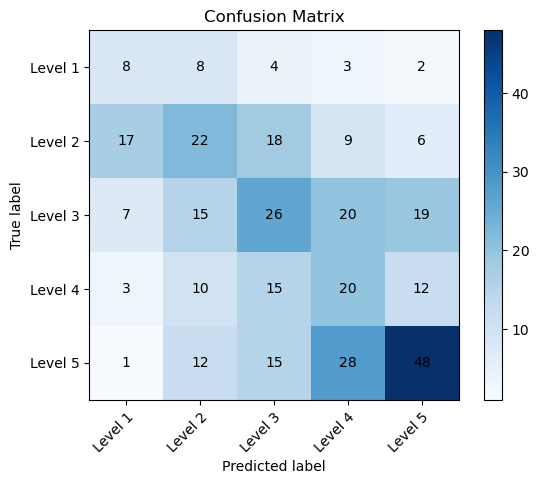

Feature Importance Rankings:
1. DESWLltd: 2.680959095862779
2. DESWLlt: 2.431543192605458
3. DESWC: 2.3602121184590676
4. WRDAOAc: 2.156783544716176
5. RDL2: 2.1128449371396627
6. symbol_count: 2.050623939752656
7. PCTEMPz: 2.0331917818827088
8. CNCAll: 2.029834587787887
9. WRDHYPv: 2.026298295968071
10. PCVERBz: 2.0176139027161515
11. PCDCz: 1.8949389398344432
12. WRDMEAc: 1.8839365863818545
13. RDFKGL: 1.8575792489816845
14. PCSYNp: 1.8358690575348593
15. PCSYNz: 1.8351804426050005
16. PCCNCz: 1.8346583865092205
17. WRDHYPn: 1.8300119437310352
18. WRDADJ: 1.826054090285868
19. DESWLsyd: 1.8111630100901956
20. PCREFz: 1.7868286700709919
21. PCCONNz: 1.7756904729105876
22. no_of_variables: 1.7721622829164971
23. WRDFRQmc: 1.7330668832027982
24. PCNARz: 1.731684894119577
25. WRDHYPnv: 1.7211370124740666
26. DESSL: 1.7172658714382778
27. WRDIMGc: 1.6722611968408594
28. DESWLsy: 1.6584283720088424
29. WRDADV: 1.6333318235953675
30. WRDPRO: 1.6213894896153664
31. PCREFp: 1.6132329967060197

In [172]:
model(data6, use_smote_technique=0)

In [177]:
data6 = get_cohmetrix_merged_data(MATH_NUM_FEATURES + MANDATORY_FEATURES + GPT_TARGET_FEATURE)

Shape of cohmetric features:  (3584, 107)
math features shape:  (1736, 16)
final dataframe shape:  (1736, 121)


Class distribution before SMOTE: Counter({3: 548, 2: 525, 4: 212, 1: 61, 5: 42})
Class distribution after SMOTE: Counter({2: 548, 3: 548, 4: 548, 5: 548, 1: 548})
Best Parameters:  {'criterion': 'entropy', 'max_depth': 13, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 200, 'oob_score': True}
Best Score:  0.7445255474452555
train_evaluation:

              precision    recall  f1-score   support

           1       1.00      0.99      1.00       551
           2       0.99      0.99      0.99       548
           3       0.99      0.99      0.99       547
           4       0.99      1.00      0.99       545
           5       1.00      1.00      1.00       549

    accuracy                           0.99      2740
   macro avg       0.99      0.99      0.99      2740
weighted avg       0.99      0.99      0.99      2740

[[548   2   0   1   0]
 [  0 540   5   2   1]
 [  0   5 541   1   0]
 [  0   1   1 543   0]
 [  0   0   1   1 547]]

test_evaluation:

              

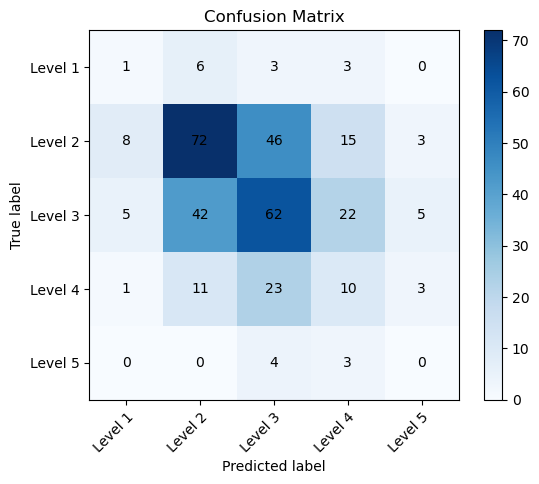

Feature Importance Rankings:
1. DESWLltd: 2.1325802337218707
2. RDL2: 1.948693420261417
3. SYNLE: 1.90263214746621
4. DESWLlt: 1.8806674087988302
5. PCCNCz: 1.863186077496802
6. PCCNCp: 1.810347313231692
7. PCNARp: 1.7127693768247254
8. WRDPOLc: 1.6996952160829033
9. no_of_variables: 1.6783964427613423
10. DESWC: 1.6735062155488312
11. PCCONNz: 1.6602785984120894
12. PCCONNp: 1.622087103241319
13. WRDADJ: 1.6074012159583773
14. DESSL: 1.591692084517749
15. WRDFAMc: 1.591412108835883
16. WRDPRO: 1.5828513645646574
17. DRAP: 1.559444579615729
18. PCTEMPz: 1.5372988485999504
19. DRPP: 1.5002197959552437
20. PCSYNp: 1.4947709566428111
21. WRDHYPv: 1.4881290665803797
22. WRDMEAc: 1.4751105790687402
23. WRDADV: 1.4602399010365696
24. PCSYNz: 1.4580828981056166
25. WRDIMGc: 1.4404373304514801
26. SMINTEp: 1.4358449942325708
27. PCREFz: 1.4345384447061142
28. SMTEMP: 1.4284558480335248
29. CNCAll: 1.4230079781554594
30. WRDAOAc: 1.4212925695357455
31. PCREFp: 1.419615384084563
32. WRDCNCc: 1.4

In [164]:
model(data6, target_feature=GPT_TARGET_FEATURE[0])

Best Parameters:  {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 9, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 100, 'oob_score': True}
Best Score:  0.4668649196166532
train_evaluation:

              precision    recall  f1-score   support

           1       1.00      0.80      0.89        76
           2       0.92      0.93      0.92       523
           3       0.92      0.96      0.94       528
           4       0.93      0.93      0.93       214
           5       1.00      0.89      0.94        47

    accuracy                           0.93      1388
   macro avg       0.96      0.90      0.93      1388
weighted avg       0.93      0.93      0.93      1388

[[ 61   7   6   2   0]
 [  0 484  32   7   0]
 [  0  19 505   4   0]
 [  0  12   4 198   0]
 [  0   3   1   1  42]]

test_evaluation:

              precision    recall  f1-score   support

           1       0.07      0.17      0.10         6
           2       0.66      0.52 

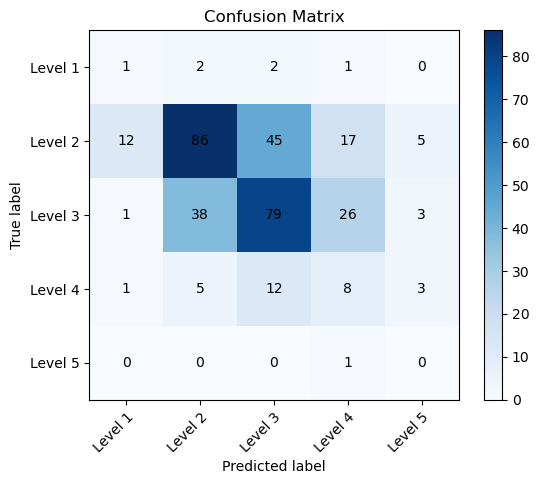

Feature Importance Rankings:
1. DESWLltd: 3.058262551186834
2. DESWLlt: 2.3596418007650426
3. CNCAll: 2.069848165308432
4. PCSYNz: 2.0189554225091038
5. PCCONNz: 1.9323690764570567
6. PCCNCz: 1.9291678630869387
7. DESWC: 1.879538524668327
8. PCREFz: 1.8641087491151822
9. DRNEG: 1.8521558393835882
10. PCTEMPz: 1.8231604510092994
11. RDFRE: 1.8110209492930598
12. PCVERBz: 1.8105441779598215
13. WRDAOAc: 1.7890401127116071
14. RDL2: 1.7387158535132432
15. WRDHYPv: 1.7293543650601306
16. WRDHYPn: 1.700883743877752
17. PCDCz: 1.6604366814744511
18. DRPP: 1.6580258542567585
19. DRAP: 1.6519383283611238
20. WRDPRO: 1.6358603867323855
21. WRDADJ: 1.6293393015145152
22. DESSL: 1.6185460216481609
23. PCNARz: 1.6032462524611393
24. WRDIMGc: 1.5920125113393673
25. PCREFp: 1.565312563282251
26. DESWLsyd: 1.509233279520506
27. SYNMEDwrd: 1.4574639322405152
28. no_of_pow: 1.4509540163445822
29. number_of_digits: 1.444909025909715
30. DESWLsy: 1.43799254432342
31. WRDHYPnv: 1.397650215828566
32. PCSYN

In [178]:
model(data6, target_feature=GPT_TARGET_FEATURE[0], use_smote_technique=0)

### Cohmetrix plus math cat

In [179]:
data6 = get_cohmetrix_merged_data(MATH_CAT_FEATURES + MANDATORY_FEATURES + TARGET_FEATURE)

Shape of cohmetric features:  (3584, 107)
math features shape:  (1736, 14)
final dataframe shape:  (1736, 119)


Class distribution before SMOTE: Counter({'Level 5': 348, 'Level 4': 316, 'Level 3': 313, 'Level 2': 269, 'Level 1': 142})
Class distribution after SMOTE: Counter({'Level 5': 348, 'Level 4': 348, 'Level 3': 348, 'Level 1': 348, 'Level 2': 348})
Best Parameters:  {'criterion': 'entropy', 'max_depth': 13, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 200, 'oob_score': True}
Best Score:  0.5379310344827586
train_evaluation:

              precision    recall  f1-score   support

     Level 1       1.00      1.00      1.00       348
     Level 2       0.99      0.99      0.99       346
     Level 3       0.99      0.99      0.99       349
     Level 4       1.00      1.00      1.00       348
     Level 5       1.00      1.00      1.00       349

    accuracy                           1.00      1740
   macro avg       1.00      1.00      1.00      1740
weighted avg       1.00      1.00      1.00      1740

[[347   1   0   0   0]
 [  1 344   1   0   0]
 [  0   2 346   1   0

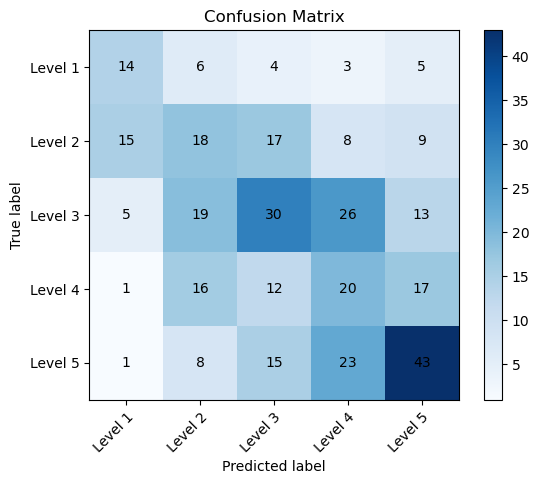

Feature Importance Rankings:
1. DESWLlt: 2.760521028883334
2. DESWLltd: 2.7307251302786373
3. DESWC: 2.4431546215984867
4. no_of_variables: 2.4116023039997216
5. CNCAll: 2.1457140937006414
6. PCTEMPz: 2.049645692455259
7. RDL2: 2.027221287329909
8. WRDADJ: 2.024707200326155
9. WRDAOAc: 1.9943413083587676
10. WRDMEAc: 1.9778521439252401
11. DESSL: 1.9705214905022157
12. PCVERBz: 1.9423794284612268
13. WRDHYPv: 1.9311624002395649
14. PCCNCz: 1.908687903415025
15. PCDCz: 1.8644405899389975
16. PCCONNz: 1.8555428883506913
17. WRDHYPn: 1.852068912551152
18. PCSYNz: 1.8501056776122575
19. RDFKGL: 1.8333166766475693
20. PCNARz: 1.8173664334354043
21. WRDPOLc: 1.7974424679907108
22. DRAP: 1.785997569200413
23. PCREFz: 1.7634974818215525
24. WRDIMGc: 1.7363948860310736
25. DESWLsyd: 1.7310874473207103
26. DESWLsy: 1.7134135491393039
27. WRDADV: 1.7101621721235756
28. WRDFRQmc: 1.7060208998383972
29. PCREFp: 1.676511360728535
30. RDFRE: 1.6619739558008062
31. DRPP: 1.655914535511494
32. PCSYNp: 

In [180]:
model(data6)

Best Parameters:  {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 9, 'max_features': 'auto', 'min_samples_split': 5, 'n_estimators': 100, 'oob_score': True}
Best Score:  0.39336415344258885
train_evaluation:

              precision    recall  f1-score   support

     Level 1       0.99      0.89      0.94       159
     Level 2       0.93      0.95      0.94       263
     Level 3       0.92      0.95      0.94       302
     Level 4       0.96      0.96      0.96       313
     Level 5       0.97      0.96      0.96       351

    accuracy                           0.95      1388
   macro avg       0.95      0.94      0.95      1388
weighted avg       0.95      0.95      0.95      1388

[[141  10   4   4   0]
 [  0 250   7   2   4]
 [  1   7 288   4   2]
 [  0   1   5 302   5]
 [  0   1   9   4 337]]

test_evaluation:

              precision    recall  f1-score   support

     Level 1       0.31      0.31      0.31        35
     Level 2       0.24      0

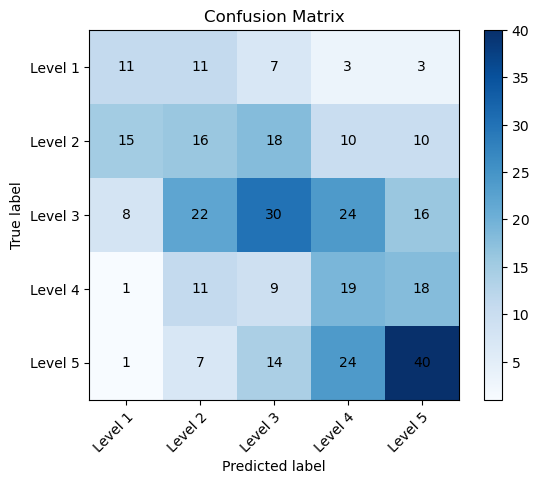

Feature Importance Rankings:
1. DESWLltd: 3.0643412814858566
2. DESWC: 3.00500512150837
3. WRDMEAc: 2.4091051943038075
4. WRDADJ: 2.4059666177018526
5. DESWLlt: 2.3622924675423804
6. RDL2: 2.29679908290245
7. CNCAll: 2.295674768879953
8. no_of_variables: 2.2871810258940424
9. DESSL: 2.1672795214105145
10. WRDHYPv: 2.164539356141539
11. PCTEMPz: 2.1462358290769195
12. WRDHYPnv: 2.0101366247434598
13. PCVERBz: 1.958309759679917
14. WRDAOAc: 1.935072231449673
15. PCSYNz: 1.9221712905224762
16. WRDHYPn: 1.9036336820059503
17. RDFKGL: 1.890302594353234
18. WRDPOLc: 1.847502300783087
19. PCREFz: 1.847119164434394
20. PCCONNz: 1.831820993561524
21. DESWLsyd: 1.7235603710644536
22. PCSYNp: 1.7072439050615813
23. WRDFRQmc: 1.6958201635707433
24. WRDIMGc: 1.6885402579515434
25. has_symbol: 1.6646156764939124
26. DRAP: 1.6343213465021968
27. PCDCz: 1.6302972586904065
28. WRDPRO: 1.6193337984111216
29. PCCNCp: 1.578868665805151
30. DRPP: 1.5727355304640003
31. PCNARz: 1.5677791659227793
32. SYNMED

In [181]:
model(data6, use_smote_technique=0)

In [183]:
data6 = get_cohmetrix_merged_data(MATH_CAT_FEATURES + MANDATORY_FEATURES + GPT_TARGET_FEATURE)

Shape of cohmetric features:  (3584, 107)
math features shape:  (1736, 14)
final dataframe shape:  (1736, 119)


Class distribution before SMOTE: Counter({3: 548, 2: 525, 4: 212, 1: 61, 5: 42})
Class distribution after SMOTE: Counter({2: 548, 3: 548, 4: 548, 5: 548, 1: 548})
Best Parameters:  {'criterion': 'entropy', 'max_depth': 13, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 200, 'oob_score': True}
Best Score:  0.7448905109489051
train_evaluation:

              precision    recall  f1-score   support

           1       1.00      0.99      1.00       551
           2       0.99      0.98      0.98       549
           3       0.98      0.99      0.99       543
           4       0.99      0.99      0.99       547
           5       1.00      0.99      1.00       550

    accuracy                           0.99      2740
   macro avg       0.99      0.99      0.99      2740
weighted avg       0.99      0.99      0.99      2740

[[548   2   0   1   0]
 [  0 540   7   1   1]
 [  0   3 539   1   0]
 [  0   2   1 544   0]
 [  0   1   1   1 547]]

test_evaluation:

              

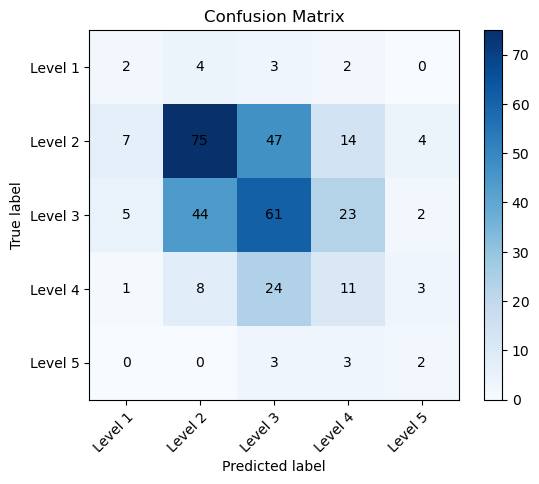

Feature Importance Rankings:
1. DESWLltd: 2.2314232092266777
2. RDL2: 2.079670617596191
3. has_pow: 1.9850700294652932
4. DESWLlt: 1.9168552856961407
5. DESSL: 1.798602240883696
6. PCCNCp: 1.795900748413275
7. SYNLE: 1.770556646064894
8. PCCNCz: 1.7481646650337173
9. DESWC: 1.7416492784643973
10. PCCONNp: 1.736627850806498
11. DRAP: 1.690847248849825
12. WRDFAMc: 1.6859944979159398
13. WRDPRO: 1.6705322135474174
14. WRDPOLc: 1.6200755088412961
15. PCNARp: 1.6167060582093102
16. no_of_variables: 1.5897451465781203
17. WRDHYPv: 1.561007798224482
18. PCCONNz: 1.5540673732039652
19. PCSYNz: 1.5454857382906058
20. WRDADJ: 1.5355334290059846
21. PCNARz: 1.5325413285853784
22. LDMTLD: 1.5240460626025947
23. PCREFz: 1.5077752487601503
24. PCTEMPz: 1.5070748110065049
25. WRDCNCc: 1.5043865903198252
26. RDFRE: 1.502627749660971
27. WRDMEAc: 1.4862440495226255
28. CNCAll: 1.475397952568286
29. WRDADV: 1.470864799443632
30. DRPP: 1.4300118842814487
31. SMTEMP: 1.4217125649090625
32. LDVOCD: 1.4204

In [184]:
model(data6, target_feature=GPT_TARGET_FEATURE[0])

Best Parameters:  {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 13, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 200, 'oob_score': True}
Best Score:  0.46037971067189565
train_evaluation:

              precision    recall  f1-score   support

           1       1.00      0.97      0.98        63
           2       0.98      0.99      0.98       521
           3       0.99      0.99      0.99       544
           4       0.99      0.98      0.99       214
           5       1.00      0.91      0.95        46

    accuracy                           0.99      1388
   macro avg       0.99      0.97      0.98      1388
weighted avg       0.99      0.99      0.99      1388

[[ 61   2   0   0   0]
 [  0 515   6   0   0]
 [  0   3 540   1   0]
 [  0   3   1 210   0]
 [  0   2   1   1  42]]

test_evaluation:

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         5
           2       0.59      

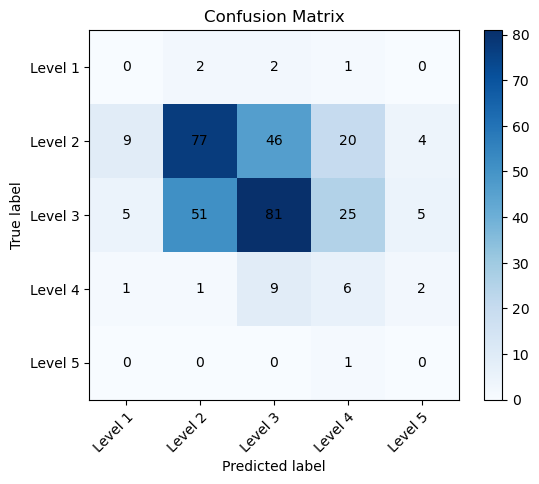

Feature Importance Rankings:
1. DESWLltd: 2.8797582589869988
2. DESWLlt: 2.71713409978229
3. PCCONNz: 2.1621443316698703
4. PCCNCz: 2.1147544857852525
5. PCTEMPz: 2.109774632264794
6. RDL2: 2.078339816841918
7. PCSYNz: 2.045507396944037
8. DESWC: 2.032059380440766
9. PCREFz: 1.9784685117960845
10. WRDIMGc: 1.9562215261817033
11. DRAP: 1.9512552993097398
12. PCVERBz: 1.9475741758412177
13. WRDHYPv: 1.9357437625665577
14. WRDADJ: 1.8861834587380653
15. WRDAOAc: 1.8716942423259275
16. DRPP: 1.826785648470928
17. DESWLsy: 1.8088567572337413
18. CNCAll: 1.7990432167671364
19. PCDCz: 1.7938454560216393
20. DESWLsyd: 1.776804541538172
21. PCREFp: 1.7581866916176385
22. WRDPRO: 1.754108699112307
23. RDFRE: 1.7509062350544766
24. PCNARz: 1.7375237356248237
25. WRDCNCc: 1.7129803498404266
26. DRNEG: 1.6882870887420693
27. RDFKGL: 1.6625914663938715
28. WRDPOLc: 1.6621916652922109
29. WRDHYPnv: 1.6562057503135659
30. PCCONNp: 1.6479350319392354
31. WRDFRQmc: 1.6472537925600919
32. DESSL: 1.598039

In [185]:
model(data6, target_feature=GPT_TARGET_FEATURE[0], use_smote_technique=0)

### Math cat + num features

In [186]:
data6 = get_cohmetrix_merged_data(MATH_CAT_FEATURES + MATH_NUM_FEATURES + MANDATORY_FEATURES + TARGET_FEATURE)

Shape of cohmetric features:  (3584, 107)
math features shape:  (1736, 25)
final dataframe shape:  (1736, 130)


Class distribution before SMOTE: Counter({'Level 5': 348, 'Level 4': 316, 'Level 3': 313, 'Level 2': 269, 'Level 1': 142})
Class distribution after SMOTE: Counter({'Level 5': 348, 'Level 4': 348, 'Level 3': 348, 'Level 1': 348, 'Level 2': 348})
Best Parameters:  {'criterion': 'entropy', 'max_depth': 13, 'max_features': 'auto', 'min_samples_split': 5, 'n_estimators': 200, 'oob_score': True}
Best Score:  0.5488505747126438
train_evaluation:

              precision    recall  f1-score   support

     Level 1       0.99      0.98      0.99       352
     Level 2       0.98      0.99      0.98       345
     Level 3       0.98      0.97      0.98       350
     Level 4       0.99      0.99      0.99       348
     Level 5       0.99      1.00      0.99       345

    accuracy                           0.99      1740
   macro avg       0.99      0.99      0.99      1740
weighted avg       0.99      0.99      0.99      1740

[[346   4   2   0   0]
 [  1 340   3   0   1]
 [  1   4 341   3   1

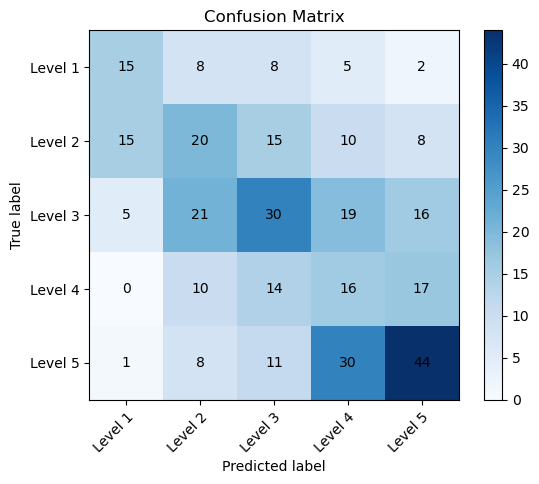

Feature Importance Rankings:
1. DESWC: 2.4918040882390273
2. DESWLltd: 2.2638885865108307
3. DESWLlt: 2.228467205934803
4. symbol_count: 2.0997521393153518
5. RDL2: 2.099619663147996
6. no_of_variables: 2.060173690613044
7. WRDMEAc: 1.982677951105896
8. CNCAll: 1.9646167263572731
9. PCTEMPz: 1.9057443311180902
10. DESSL: 1.905611270600607
11. WRDHYPv: 1.8504217097074536
12. PCSYNz: 1.835894218438535
13. WRDPOLc: 1.8134730231206753
14. WRDAOAc: 1.811100187874695
15. PCVERBz: 1.8025697503311466
16. WRDIMGc: 1.7916942503534705
17. WRDADJ: 1.751462516727282
18. WRDPRO: 1.7284281068602025
19. WRDHYPn: 1.7165432397988833
20. DESWLsyd: 1.7014437118469432
21. DESWLsy: 1.672635512070588
22. PCCONNz: 1.6672900291116959
23. PCCNCz: 1.6631086929527417
24. PCDCz: 1.6279976390205904
25. WRDADV: 1.6141897628381756
26. PCSYNp: 1.607713721430424
27. WRDFRQmc: 1.603904493489021
28. WRDFAMc: 1.5929657227140224
29. DRNEG: 1.592807308924798
30. RDFKGL: 1.5891018321747612
31. PCREFz: 1.5887075650612452
32. 

In [187]:
model(data6)

Best Parameters:  {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 13, 'max_features': 'auto', 'min_samples_split': 5, 'n_estimators': 200, 'oob_score': True}
Best Score:  0.39265511778302986
train_evaluation:

              precision    recall  f1-score   support

     Level 1       1.00      0.95      0.97       150
     Level 2       0.96      0.99      0.98       262
     Level 3       0.98      0.98      0.98       314
     Level 4       0.99      0.99      0.99       315
     Level 5       0.99      1.00      1.00       347

    accuracy                           0.98      1388
   macro avg       0.99      0.98      0.98      1388
weighted avg       0.99      0.98      0.98      1388

[[142   6   2   0   0]
 [  0 259   1   1   1]
 [  0   4 308   2   0]
 [  0   0   2 312   1]
 [  0   0   0   1 346]]

test_evaluation:

              precision    recall  f1-score   support

     Level 1       0.31      0.35      0.33        31
     Level 2       0.31      

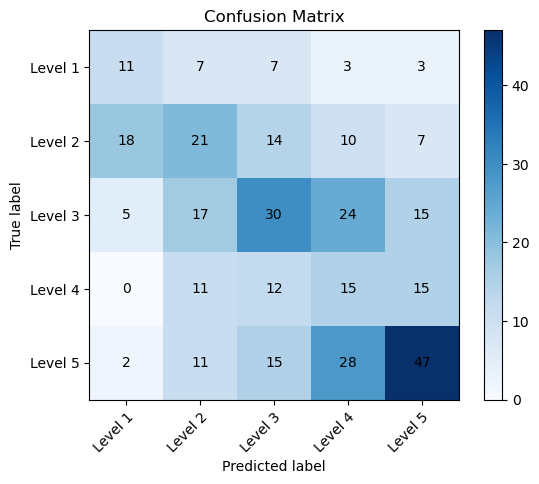

Feature Importance Rankings:
1. DESWLltd: 2.482606420156865
2. DESWLlt: 2.4750669886383934
3. DESWC: 2.4301951542542026
4. PCTEMPz: 2.027024433651136
5. PCSYNz: 1.997661146226696
6. WRDMEAc: 1.975191248860511
7. RDL2: 1.9738011785124607
8. WRDHYPv: 1.9601667419089812
9. PCCNCz: 1.9392883411936468
10. CNCAll: 1.9392198509737737
11. WRDPOLc: 1.9188622264848427
12. WRDAOAc: 1.9123179888945767
13. WRDADJ: 1.8964914334008403
14. DESWLsyd: 1.8383486729390053
15. WRDIMGc: 1.8174181496613662
16. WRDFRQmc: 1.8148922137645063
17. WRDHYPn: 1.8137116943820994
18. PCSYNp: 1.80764378955964
19. RDFKGL: 1.7962708701758683
20. PCDCz: 1.7908905001469169
21. DESSL: 1.7856511687393093
22. PCVERBz: 1.7268319669340817
23. PCCONNz: 1.7192978169353983
24. PCNARz: 1.6998920706776877
25. no_of_variables: 1.6881979188676468
26. WRDHYPnv: 1.6763237303479368
27. DRAP: 1.6739745553809458
28. DESWLsy: 1.6545943208070446
29. PCREFz: 1.6451841373207825
30. symbol_count: 1.6447986684588016
31. PCCONNp: 1.59819723748204

In [188]:
model(data6, use_smote_technique=0)

In [189]:
data6 = get_cohmetrix_merged_data(MATH_CAT_FEATURES + MATH_NUM_FEATURES + MANDATORY_FEATURES + GPT_TARGET_FEATURE)

Shape of cohmetric features:  (3584, 107)
math features shape:  (1736, 25)
final dataframe shape:  (1736, 130)


Class distribution before SMOTE: Counter({3: 548, 2: 525, 4: 212, 1: 61, 5: 42})
Class distribution after SMOTE: Counter({2: 548, 3: 548, 4: 548, 5: 548, 1: 548})
Best Parameters:  {'criterion': 'gini', 'max_depth': 13, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 200, 'oob_score': True}
Best Score:  0.7518248175182481
train_evaluation:

              precision    recall  f1-score   support

           1       1.00      0.99      1.00       551
           2       0.99      0.98      0.98       552
           3       0.98      0.99      0.99       542
           4       0.99      0.99      0.99       546
           5       1.00      1.00      1.00       549

    accuracy                           0.99      2740
   macro avg       0.99      0.99      0.99      2740
weighted avg       0.99      0.99      0.99      2740

[[548   2   0   1   0]
 [  0 541   8   2   1]
 [  0   3 538   1   0]
 [  0   2   1 543   0]
 [  0   0   1   1 547]]

test_evaluation:

              pre

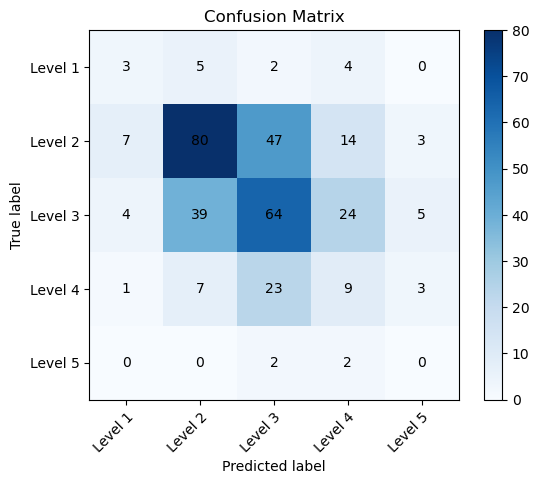

Feature Importance Rankings:
1. DESWLltd: 2.062972102719235
2. RDL2: 1.8749225001211927
3. DESWC: 1.8268671886528947
4. DESWLlt: 1.7834040489388323
5. PCCNCz: 1.735082751296641
6. DESSL: 1.6347224908174554
7. DRAP: 1.6273131421460172
8. PCCNCp: 1.598190320026225
9. PCTEMPz: 1.568812338073194
10. PCNARp: 1.5482476983819493
11. PCSYNz: 1.5465053856219448
12. PCCONNz: 1.5221829860411042
13. WRDMEAc: 1.4959747973409367
14. PCNARz: 1.4726961795448592
15. PCCONNp: 1.4719315251769933
16. PCSYNp: 1.469428470932713
17. WRDFAMc: 1.4675747068124325
18. WRDADJ: 1.4650700085810782
19. WRDPRO: 1.451425241965705
20. LDVOCD: 1.4297192109448589
21. WRDFRQmc: 1.4182533176238659
22. DRNEG: 1.4099737990432384
23. SMTEMP: 1.4049027703342591
24. DRPP: 1.4041613857279391
25. WRDCNCc: 1.4019935573968592
26. PCDCz: 1.3949770180810563
27. no_of_variables: 1.39238418686496
28. PCREFz: 1.3898385279693595
29. WRDAOAc: 1.3805832949368475
30. SYNMEDwrd: 1.3737693596059763
31. DESWLsy: 1.3562287432996538
32. WRDHYPv:

In [190]:
model(data6, target_feature=GPT_TARGET_FEATURE[0])

Best Parameters:  {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 13, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 100, 'oob_score': True}
Best Score:  0.45962911980884613
train_evaluation:

              precision    recall  f1-score   support

           1       1.00      0.97      0.98        63
           2       0.98      0.99      0.99       523
           3       0.99      0.99      0.99       545
           4       0.99      0.99      0.99       212
           5       1.00      0.93      0.97        45

    accuracy                           0.99      1388
   macro avg       0.99      0.97      0.98      1388
weighted avg       0.99      0.99      0.99      1388

[[ 61   2   0   0   0]
 [  0 517   5   1   0]
 [  0   3 541   1   0]
 [  0   2   1 209   0]
 [  0   1   1   1  42]]

test_evaluation:

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         5
           2       0.60      0.5

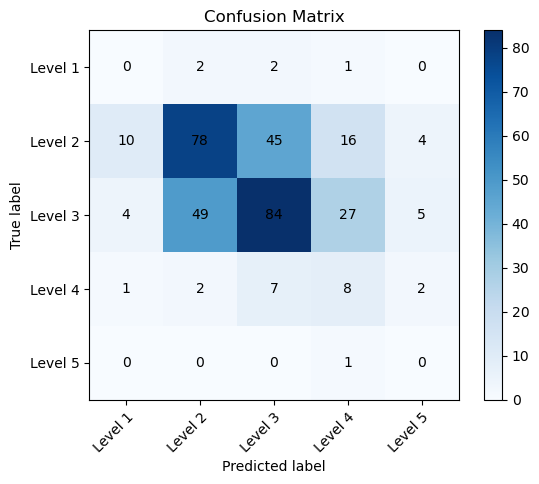

Feature Importance Rankings:
1. DESWLltd: 2.6108738987584355
2. DESWLlt: 2.5775389411982315
3. PCCONNz: 1.985205482380405
4. WRDAOAc: 1.917149609961831
5. PCDCz: 1.8920679817123067
6. PCTEMPz: 1.8834034559357786
7. WRDHYPv: 1.8787958464938996
8. PCCNCz: 1.865731025263783
9. PCREFz: 1.8362486041500803
10. RDL2: 1.8174641720383342
11. PCSYNp: 1.8121233661684162
12. DRNEG: 1.8113642542840984
13. DESWC: 1.7949829754939923
14. WRDPRO: 1.7683697973316699
15. DRAP: 1.7436008442183082
16. DESWLsyd: 1.737805329246004
17. PCREFp: 1.7227764500105072
18. PCSYNz: 1.7183865219175654
19. WRDADJ: 1.6839907099264342
20. WRDFRQmc: 1.6631928410271528
21. WRDIMGc: 1.6263208687999278
22. WRDADV: 1.6078641497974726
23. RDFKGL: 1.6054003218773272
24. PCNARz: 1.5979260571341698
25. RDFRE: 1.5942738157558711
26. PCVERBz: 1.5640025742127035
27. PCCONNp: 1.5074527794079193
28. WRDHYPnv: 1.4894201223984769
29. LDVOCD: 1.4841192948930064
30. SYNMEDwrd: 1.4771326818422987
31. WRDMEAc: 1.4663991278761368
32. DESWLsy

In [191]:
model(data6, target_feature=GPT_TARGET_FEATURE[0], use_smote_technique=0)

## Logistic regression analysis
Math cols with target variable and do logistic regression and apply this on the dataset

In [111]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logistic_analysis_data = math_problems[MATH_NUM_FEATURES + MANDATORY_FEATURES + TARGET_FEATURE]
# Create and fit the logistic regression model
model = LogisticRegression(multi_class='ovr', solver='liblinear', class_weight="balanced")
X = logistic_analysis_data.drop(columns=TARGET_FEATURE)
Y = logistic_analysis_data['level']

# Split the data into test and train
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 2, stratify = Y)
y_train = y_train.apply(club_class)

y_test = y_test.apply(club_class)

model.fit(X_train, y_train)

# Retrieve the overall coefficients
overall_coefficients = model.coef_

# Print the overall coefficients
for i,feature in enumerate(X.columns):
    print(f"{feature}: {overall_coefficients[0, i]}")

exp_count: -0.13285062638993014
mod_count: -0.05195134339558322
log_count: 0.003062765001999391
fracs_count: -0.07127037582525844
eqlts_count: -0.06975044764235987
neqlts_count: -0.13663640001255226
max_degree_of_equations: 0.00014721468607720858
number_of_digits: 0.0094984001792685
number_of_numbers: 0.009644840635366844
no_of_equations: -0.19711152624618225
no_of_variables: -0.10576109959154417
type: 0.019597590066744573


In [112]:
# Predict the labels for the test set
y_pred = model.predict(X_test)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.4115566037735849


## ANN Analysis

In [119]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Create the neural network model
model = Sequential()

# Add the input layer
model.add(Dense(units=64, activation='relu', input_dim=X.shape[1]))  # 10 input features, 64 hidden units

# Add the first hidden layer
model.add(Dense(units=32, activation='relu'))  # 32 hidden units

Dropout(0.2)

# Add the second hidden layer
model.add(Dense(units=16, activation='relu'))  # 16 hidden units

Dropout(0.2)

# Add the output softmax layer
model.add(Dense(units=5, activation='softmax'))  # Output layer with 5 units (one for each class)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                832       
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 5)                 85        
                                                                 
Total params: 3,525
Trainable params: 3,525
Non-trainable params: 0
_________________________________________________________________


In [117]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Fit and transform the target attribute
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)


In [120]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
106/106 [==============================] - 0s 1ms/step - loss: 1.4086 - accuracy: 0.4250 - val_loss: 1.2346 - val_accuracy: 0.4410
Epoch 2/20
106/106 [==============================] - 0s 675us/step - loss: 1.2951 - accuracy: 0.4578 - val_loss: 1.0946 - val_accuracy: 0.4505
Epoch 3/20
106/106 [==============================] - 0s 662us/step - loss: 1.0986 - accuracy: 0.4687 - val_loss: 1.0992 - val_accuracy: 0.4540
Epoch 4/20
106/106 [==============================] - 0s 643us/step - loss: 1.0684 - accuracy: 0.4684 - val_loss: 1.1519 - val_accuracy: 0.4717
Epoch 5/20
106/106 [==============================] - 0s 633us/step - loss: 1.1375 - accuracy: 0.4678 - val_loss: 1.1632 - val_accuracy: 0.4257
Epoch 6/20
106/106 [==============================] - 0s 638us/step - loss: 1.0550 - accuracy: 0.4669 - val_loss: 1.1095 - val_accuracy: 0.4469
Epoch 7/20
106/106 [==============================] - 0s 633us/step - loss: 1.0604 - accuracy: 0.4814 - val_loss: 1.0616 - val_accuracy: 0

In [121]:
# Get the weights of the input layer
input_layer_weights = model.layers[0].get_weights()[0]
input_layer_weights

array([[ 0.19006047,  0.0243612 , -0.07037447,  0.09958389, -0.01899001,
         0.16076362,  0.00786231,  0.0373062 , -0.09959693,  0.29570138,
        -0.05809589, -0.18653007,  0.10280969,  0.37758443,  0.36163613,
        -0.03341419, -0.16276778,  0.10357468, -0.22055225, -0.1785879 ,
        -0.3153069 ,  0.26485458, -0.03333437, -0.14144689,  0.26221192,
         0.19543241,  0.05598721,  0.1676229 , -0.04295974, -0.21690263,
         0.0609818 , -0.10365719,  0.08984071,  0.32004714, -0.21751621,
        -0.1510115 ,  0.20818543,  0.01390517, -0.05598626,  0.12874496,
        -0.2197187 ,  0.11928242,  0.00444781, -0.27252212,  0.29682764,
         0.19766659, -0.0554699 , -0.15495034, -0.32469612, -0.10887735,
         0.11845008, -0.22797568, -0.02541083,  0.21069674,  0.05785983,
         0.31158116, -0.0551687 ,  0.02454336, -0.09576803, -0.48482457,
        -0.13089691, -0.05470782, -0.2107527 , -0.31085074],
       [-0.28935045, -0.12397634,  0.08555993, -0.43286327,  0.

In [122]:
X.columns

Index(['exp_count', 'mod_count', 'log_count', 'fracs_count', 'eqlts_count',
       'neqlts_count', 'max_degree_of_equations', 'number_of_digits',
       'number_of_numbers', 'no_of_equations', 'no_of_variables', 'type'],
      dtype='object')

## Experiment 7: 

Heuristics based approach on math features

In [195]:
heuristics = {
    'no_of_exps' : 3,
    'mod_count' : 2,
    'log_count' : 3,
    'fracs_count' : 2,
    'eqlts_count' : 1,
    'neqlts_count' : 2,
    'max_degree_of_equations' : 1,
    'number_of_digits' : 1,
    'number_of_numbers' : 1,
    'no_of_equations' : 2,
    'no_of_variables' : 2
}

In [196]:
data7 = get_cohmetrix_merged_data(MATH_CAT_FEATURES + MATH_NUM_FEATURES + MANDATORY_FEATURES + TARGET_FEATURE)

Shape of cohmetric features:  (3584, 107)
math features shape:  (1736, 25)
final dataframe shape:  (1736, 130)


In [197]:
for col,weight in heuristics.items():
    data7[col] = data7[col] * weight

Class distribution before SMOTE: Counter({'Level 5': 348, 'Level 4': 316, 'Level 3': 313, 'Level 2': 269, 'Level 1': 142})
Class distribution after SMOTE: Counter({'Level 5': 348, 'Level 4': 348, 'Level 3': 348, 'Level 1': 348, 'Level 2': 348})
Best Parameters:  {'criterion': 'entropy', 'max_depth': 13, 'max_features': 'auto', 'min_samples_split': 5, 'n_estimators': 200, 'oob_score': True}
Best Score:  0.5419540229885057
train_evaluation:

              precision    recall  f1-score   support

     Level 1       1.00      0.98      0.99       353
     Level 2       0.98      0.99      0.99       342
     Level 3       0.99      0.97      0.98       355
     Level 4       0.99      0.99      0.99       345
     Level 5       0.99      1.00      1.00       345

    accuracy                           0.99      1740
   macro avg       0.99      0.99      0.99      1740
weighted avg       0.99      0.99      0.99      1740

[[347   4   2   0   0]
 [  0 340   1   0   1]
 [  1   4 344   5   1

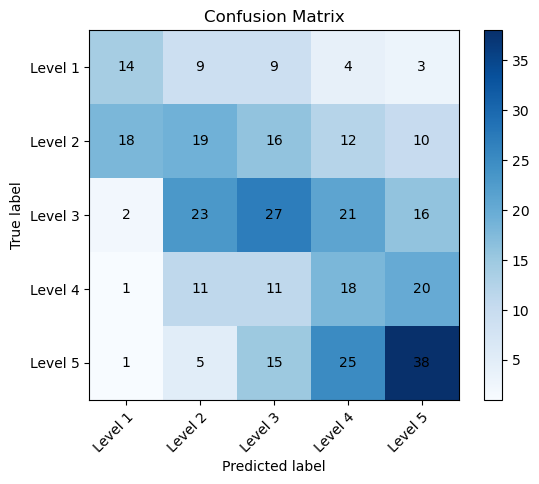

Feature Importance Rankings:
1. DESWC: 2.5721817683356862
2. DESWLlt: 2.341970870874181
3. DESWLltd: 2.22412392314252
4. no_of_variables: 2.196762898163582
5. symbol_count: 2.1824800962439244
6. CNCAll: 2.005180153627252
7. RDL2: 1.9843990457141418
8. PCTEMPz: 1.973050103904721
9. WRDMEAc: 1.9514209717340099
10. WRDHYPv: 1.9423397854464401
11. DESSL: 1.9040147071427607
12. PCSYNz: 1.8163881458217457
13. WRDPOLc: 1.7743727134109974
14. WRDAOAc: 1.7649856889277449
15. WRDHYPn: 1.75839156282269
16. PCCONNz: 1.7574580279695904
17. WRDADJ: 1.7475712542901007
18. DESWLsyd: 1.7187079352829668
19. PCSYNp: 1.7106660389733974
20. WRDFRQmc: 1.6935269079966553
21. PCVERBz: 1.6746158862713296
22. WRDIMGc: 1.6727430517412556
23. PCDCz: 1.6714566779109299
24. RDFKGL: 1.6476249172773894
25. DESWLsy: 1.6427472621761772
26. PCCNCz: 1.6277335341899568
27. WRDHYPnv: 1.6049092462005434
28. PCNARz: 1.602792357404839
29. DRNEG: 1.5849917488229133
30. WRDFAMc: 1.5735740362261088
31. PCREFz: 1.5609451755701442

In [199]:
model(data7)

Best Parameters:  {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 13, 'max_features': 'auto', 'min_samples_split': 5, 'n_estimators': 200, 'oob_score': True}
Best Score:  0.39265511778302986
train_evaluation:

              precision    recall  f1-score   support

     Level 1       1.00      0.95      0.97       150
     Level 2       0.96      0.99      0.98       262
     Level 3       0.98      0.98      0.98       314
     Level 4       0.99      0.99      0.99       315
     Level 5       0.99      1.00      1.00       347

    accuracy                           0.98      1388
   macro avg       0.99      0.98      0.98      1388
weighted avg       0.99      0.98      0.98      1388

[[142   6   2   0   0]
 [  0 259   1   1   1]
 [  0   4 308   2   0]
 [  0   0   2 312   1]
 [  0   0   0   1 346]]

test_evaluation:

              precision    recall  f1-score   support

     Level 1       0.31      0.35      0.33        31
     Level 2       0.31      

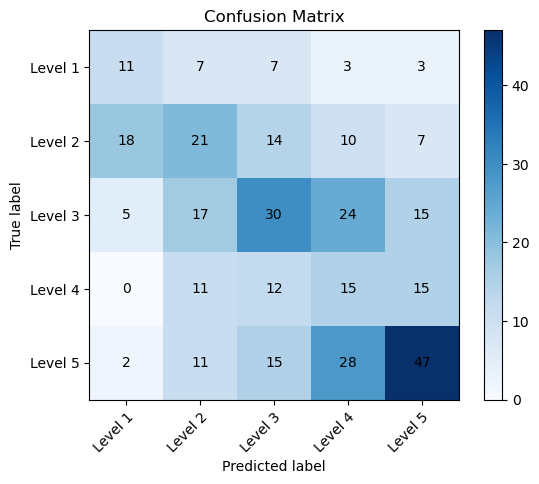

Feature Importance Rankings:
1. DESWLltd: 2.482606420156865
2. DESWLlt: 2.4750669886383934
3. DESWC: 2.4301951542542026
4. PCTEMPz: 2.027024433651136
5. PCSYNz: 1.997661146226696
6. WRDMEAc: 1.975191248860511
7. RDL2: 1.9738011785124607
8. WRDHYPv: 1.9601667419089812
9. PCCNCz: 1.9392883411936468
10. CNCAll: 1.9392198509737737
11. WRDPOLc: 1.9188622264848427
12. WRDAOAc: 1.9123179888945767
13. WRDADJ: 1.8964914334008403
14. DESWLsyd: 1.8383486729390053
15. WRDIMGc: 1.8174181496613662
16. WRDFRQmc: 1.8148922137645063
17. WRDHYPn: 1.8137116943820994
18. PCSYNp: 1.80764378955964
19. RDFKGL: 1.7962708701758683
20. PCDCz: 1.7908905001469169
21. DESSL: 1.7856511687393093
22. PCVERBz: 1.7268319669340817
23. PCCONNz: 1.7192978169353983
24. PCNARz: 1.6998920706776877
25. no_of_variables: 1.6881979188676468
26. WRDHYPnv: 1.6763237303479368
27. DRAP: 1.6739745553809458
28. DESWLsy: 1.6545943208070446
29. PCREFz: 1.6451841373207825
30. symbol_count: 1.6447986684588016
31. PCCONNp: 1.59819723748204

In [200]:
model(data7, use_smote_technique=0)

In [201]:
data7 = get_cohmetrix_merged_data(MATH_CAT_FEATURES + MATH_NUM_FEATURES + MANDATORY_FEATURES + GPT_TARGET_FEATURE)
for col,weight in heuristics.items():
    data7[col] = data7[col] * weight

Shape of cohmetric features:  (3584, 107)
math features shape:  (1736, 25)
final dataframe shape:  (1736, 130)


Class distribution before SMOTE: Counter({3: 548, 2: 525, 4: 212, 1: 61, 5: 42})
Class distribution after SMOTE: Counter({2: 548, 3: 548, 4: 548, 5: 548, 1: 548})
Best Parameters:  {'criterion': 'entropy', 'max_depth': 13, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 200, 'oob_score': True}
Best Score:  0.7536496350364964
train_evaluation:

              precision    recall  f1-score   support

           1       1.00      0.99      1.00       551
           2       0.99      0.99      0.99       547
           3       0.99      0.99      0.99       544
           4       1.00      0.99      0.99       551
           5       1.00      1.00      1.00       547

    accuracy                           0.99      2740
   macro avg       0.99      0.99      0.99      2740
weighted avg       0.99      0.99      0.99      2740

[[548   2   0   1   0]
 [  0 540   6   0   1]
 [  0   3 540   1   0]
 [  0   3   1 546   1]
 [  0   0   1   0 546]]

test_evaluation:

              

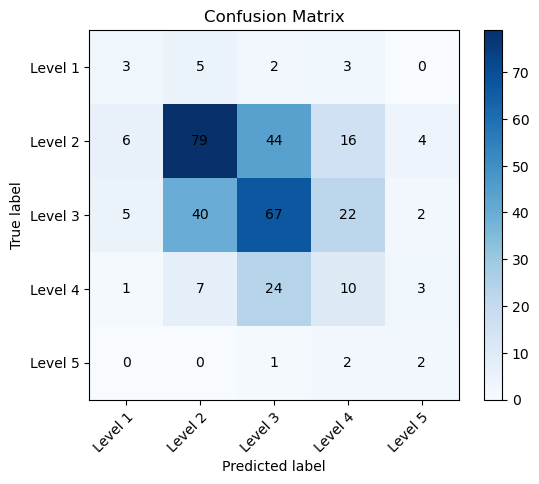

Feature Importance Rankings:
1. DESWLltd: 2.0410690143595427
2. RDL2: 1.9743790199408817
3. no_of_variables: 1.913382155696296
4. DESWC: 1.7759686984419851
5. DESWLlt: 1.744356131014146
6. PCCNCp: 1.7160893635080954
7. SYNLE: 1.6976285598230925
8. PCCNCz: 1.6807840739026934
9. DESSL: 1.6649008283289288
10. has_pow: 1.6417175475930663
11. WRDFAMc: 1.6088253009699647
12. PCCONNp: 1.5753085026652065
13. DRAP: 1.5606646501703332
14. PCNARz: 1.5593444458188779
15. WRDMEAc: 1.5490178858112613
16. WRDPRO: 1.533642684006338
17. PCNARp: 1.5308009555346087
18. LDMTLD: 1.4798139185739847
19. PCSYNz: 1.4644628863689844
20. WRDCNCc: 1.4434092548282942
21. PCTEMPz: 1.4144489293239988
22. LDVOCD: 1.41371055361521
23. WRDHYPv: 1.4117199086680807
24. WRDADJ: 1.4096874871871385
25. PCCONNz: 1.4084671081786246
26. SMTEMP: 1.4064134655625253
27. PCDCz: 1.3947555385026846
28. WRDPOLc: 1.3871798033430682
29. PCSYNp: 1.378862471527819
30. no_of_pow: 1.360295007522114
31. DRPP: 1.3511753182806077
32. CNCAll: 

In [202]:
model(data7, target_feature=GPT_TARGET_FEATURE[0])

Best Parameters:  {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 13, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 100, 'oob_score': True}
Best Score:  0.45962911980884613
train_evaluation:

              precision    recall  f1-score   support

           1       1.00      0.97      0.98        63
           2       0.98      0.99      0.99       523
           3       0.99      0.99      0.99       545
           4       0.99      0.99      0.99       212
           5       1.00      0.93      0.97        45

    accuracy                           0.99      1388
   macro avg       0.99      0.97      0.98      1388
weighted avg       0.99      0.99      0.99      1388

[[ 61   2   0   0   0]
 [  0 517   5   1   0]
 [  0   3 541   1   0]
 [  0   2   1 209   0]
 [  0   1   1   1  42]]

test_evaluation:

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         5
           2       0.60      0.5

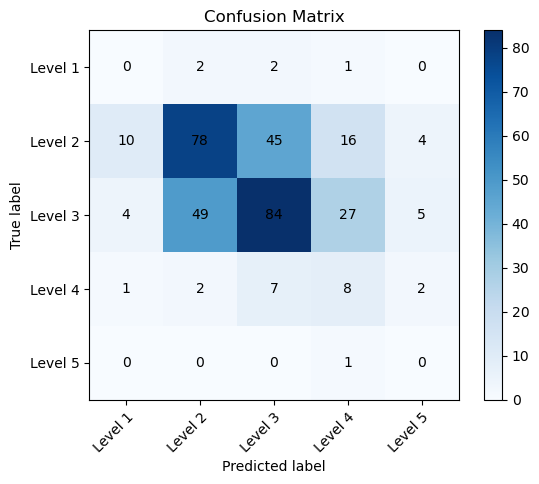

Feature Importance Rankings:
1. DESWLltd: 2.6108738987584355
2. DESWLlt: 2.5775389411982315
3. PCCONNz: 1.985205482380405
4. WRDAOAc: 1.917149609961831
5. PCDCz: 1.8920679817123067
6. PCTEMPz: 1.8834034559357786
7. WRDHYPv: 1.8787958464938996
8. PCCNCz: 1.865731025263783
9. PCREFz: 1.8362486041500803
10. RDL2: 1.8174641720383342
11. PCSYNp: 1.8121233661684162
12. DRNEG: 1.8113642542840984
13. DESWC: 1.7949829754939923
14. WRDPRO: 1.7683697973316699
15. DRAP: 1.7436008442183082
16. DESWLsyd: 1.737805329246004
17. PCREFp: 1.7227764500105072
18. PCSYNz: 1.7183865219175654
19. WRDADJ: 1.6839907099264342
20. WRDFRQmc: 1.6631928410271528
21. WRDIMGc: 1.6263208687999278
22. WRDADV: 1.6078641497974726
23. RDFKGL: 1.6054003218773272
24. PCNARz: 1.5979260571341698
25. RDFRE: 1.5942738157558711
26. PCVERBz: 1.5640025742127035
27. PCCONNp: 1.5074527794079193
28. WRDHYPnv: 1.4894201223984769
29. LDVOCD: 1.4841192948930064
30. SYNMEDwrd: 1.4771326818422987
31. WRDMEAc: 1.4663991278761368
32. DESWLsy

In [203]:
model(data7, target_feature=GPT_TARGET_FEATURE[0], use_smote_technique=0)